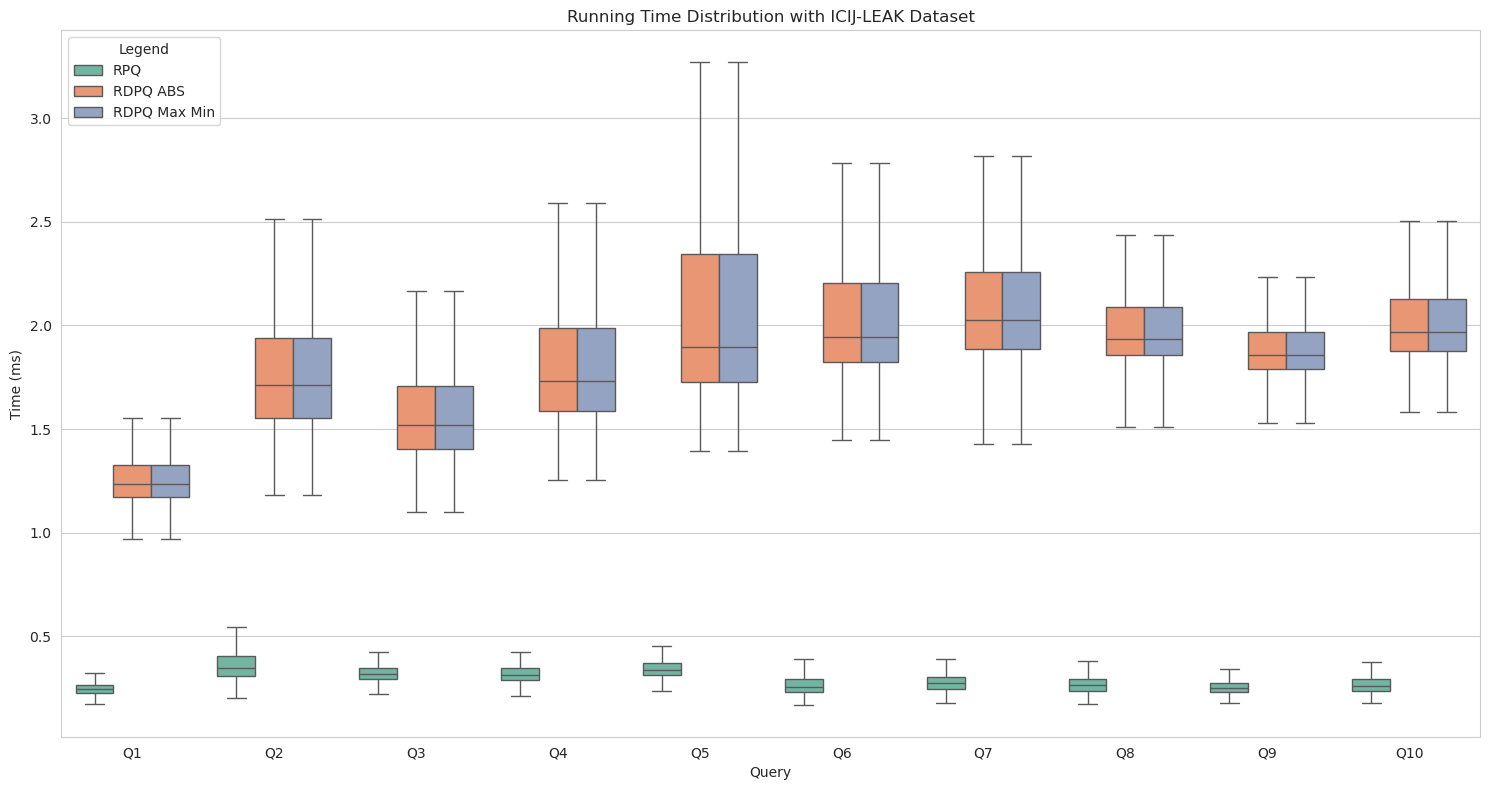

In [1]:
import pickle 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
with open("result/icij_static.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 

data_groups = []
for i in range(10):  # Q1-Q10
    id = 0
    for dtype in ["RPQ", "RDPQ ABS", "RDPQ Max Min"]:  # 3 种数据类型
        data = list(map(lambda x: x, data_ytb[i*3 + id][2])) # 乘1000转换为ms
        id = id + 1
        data_groups.append((f"Q{i+1}", dtype, data))
# 转换为 DataFrame
df_list = []
for group, dtype, values in data_groups:
    for v in values:
        df_list.append((group, dtype, v))
df = pd.DataFrame(df_list, columns=["Query", "Data Constraint", "Running Time"])

# 计算每组数据的平均值
mean_values = df.groupby(["Query", "Data Constraint"])["Running Time"].mean().reset_index()

# 设置绘图风格
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# **改回线性坐标**
# plt.yscale("log")  # 移除对数坐标

# 绘制箱线图
ax = sns.boxplot(x="Query", y="Running Time", hue="Data Constraint", data=df, palette="Set2", showfliers=False)


# **调整 Y 轴单位（毫秒）**
plt.ylabel("Time (ms)")

# 调整图例
plt.legend(title="Legend", loc="upper left")

# 添加标题
plt.title("Running Time Distribution with ICIJ-LEAK Dataset")

# 旋转 X 轴标签
# plt.xticks(rotation=45)

# **自动调整布局，防止标签重叠**
plt.tight_layout()

# 显示图表
plt.show()

In [9]:
import pickle 
import numpy as np
import functools
with open("icij-leak/icij_leak_statistic.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 
with open("icij-leak-naive/icij_leak_naive_statistic.pkl","rb+") as f1:
    data_ytb1 = pickle.loads(f1.read()) 

for i in range(len(data_ytb)):
    print(f"{data_ytb[i][1]} query, the max time difference is {format(np.max(data_ytb[i][2])-np.max(data_ytb1[i][2]),'.3f')} ms, the average time difference  is {format(np.mean(data_ytb[i][2]-np.mean(data_ytb1[i][2])),'.3f')} ms")

REGEX Q0 query, the max time difference is 0.109 ms, the average time difference  is 0.002 ms
RDPQ Q11 query, the max time difference is -0.127 ms, the average time difference  is -0.014 ms
RDPQ Q12 query, the max time difference is 0.064 ms, the average time difference  is -0.009 ms
RDPQ Q13 query, the max time difference is -0.072 ms, the average time difference  is -0.018 ms
RDPQ Q14 query, the max time difference is 0.182 ms, the average time difference  is 0.043 ms
RDPQ Q15 query, the max time difference is 2.612 ms, the average time difference  is 5.406 ms
REGEX Q1 query, the max time difference is 0.716 ms, the average time difference  is 0.247 ms
RDPQ Q21 query, the max time difference is 4.779 ms, the average time difference  is 4.113 ms
RDPQ Q22 query, the max time difference is 3.906 ms, the average time difference  is 3.548 ms
RDPQ Q23 query, the max time difference is 3.454 ms, the average time difference  is 3.507 ms
RDPQ Q24 query, the max time difference is 2.660 ms, th

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_max_comparison(path, path2, name1, name2, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare max values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'Max': np.max(values)
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]
        if query_df.empty:
            raise ValueError(f"No data available for Q{query}")
        # Plot max values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='Max', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        
        ax.set_title(f"Max: {query}")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        plt.xticks(rotation=45)
        
        # Check for log scale
        max_val = query_df['Max'].max()
        min_val = query_df['Max'].min()
        if log_scale and max_val / min_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Max: {query} (log scale)")
    
    plt.suptitle(f"Maximum Running Time Comparison: {name1} vs {name2}", y=1.02)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-max-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
def plot_mean_comparison(path, path2, name1, name2, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare mean values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'Mean': np.mean(values)
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]
        
        # Plot mean values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='Mean', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        
        ax.set_title(f"Mean: {query}")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        plt.xticks(rotation=45)
        
        # Check for log scale
        max_val = query_df['Mean'].max()
        min_val = query_df['Mean'].min()
        if log_scale and max_val / min_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Mean: {query} (log scale)")
    
    plt.suptitle(f"Average Running Time Comparison: {name1} vs {name2}", y=1.02)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-mean-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_timeout_comparison(path, path2, name1, name2, timeout, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare mean values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'TimeOut': len(list(filter(lambda x: (x/1000) > timeout, values)))
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]

        # Plot mean values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='TimeOut', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        ax.set_title(f"{query}/Timeout Threshold:{timeout}s")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Number of Time Out Queries")
        # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.6f}%"))
        plt.xticks(rotation=45)
        
        # # Check for log scale
        # max_val = query_df['Timeout'].max()
        # min_val = query_df['Mean'].min()
        # if log_scale and max_val / min_val > 100:
        #     ax.set_yscale("log")
        #     ax.set_title(f"Mean: {query} (log scale)")
    
    plt.suptitle(f"Timeout Comparison: {name1} vs {name2}", y=1.02)
# Get handles/labels from last subplot (they're the same for all)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-timeout-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_compare(path1, path2, name, timeout, log=True):
    plot_max_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", log)
    plot_mean_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", log)
    plot_timeout_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", timeout)



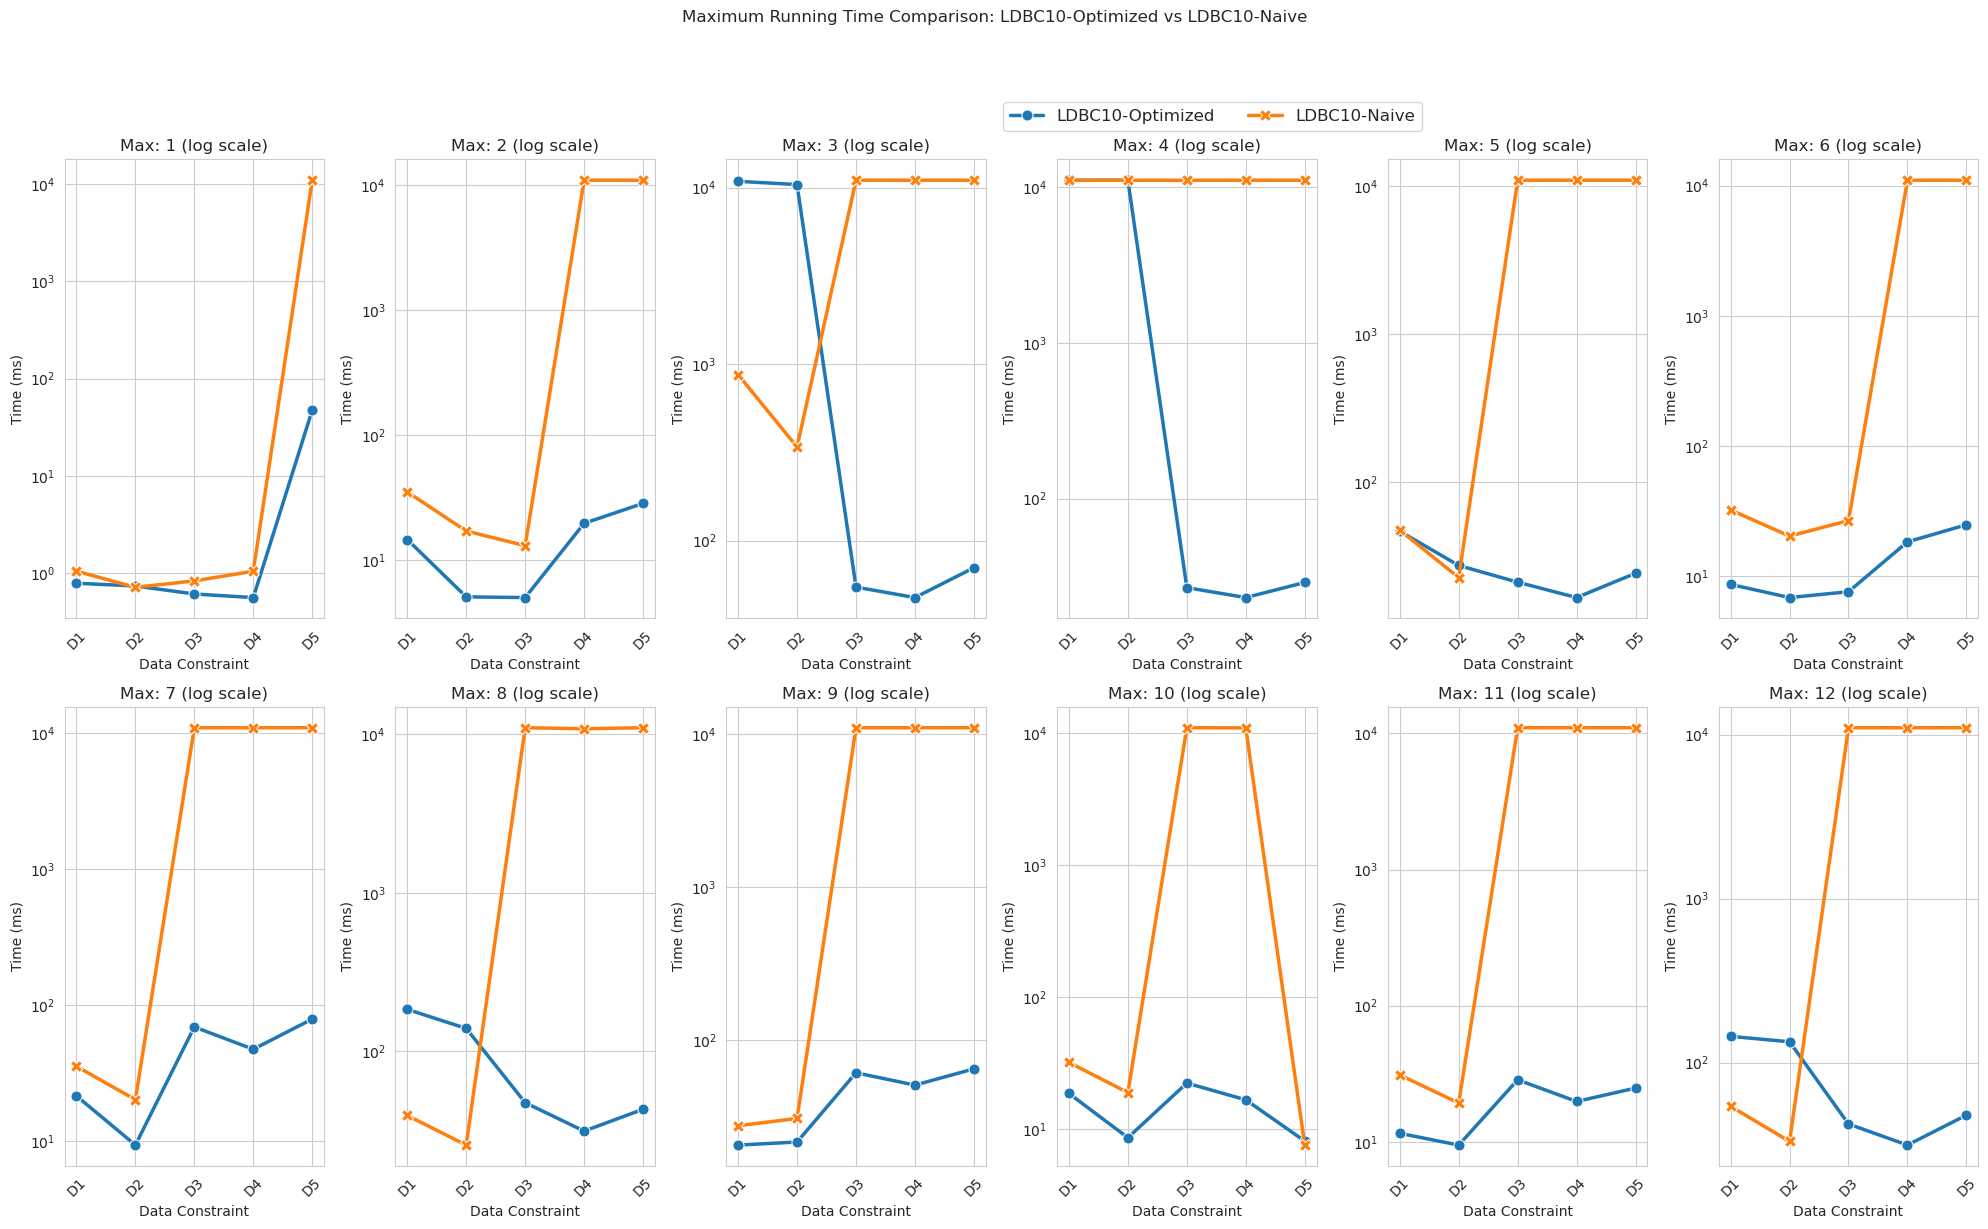

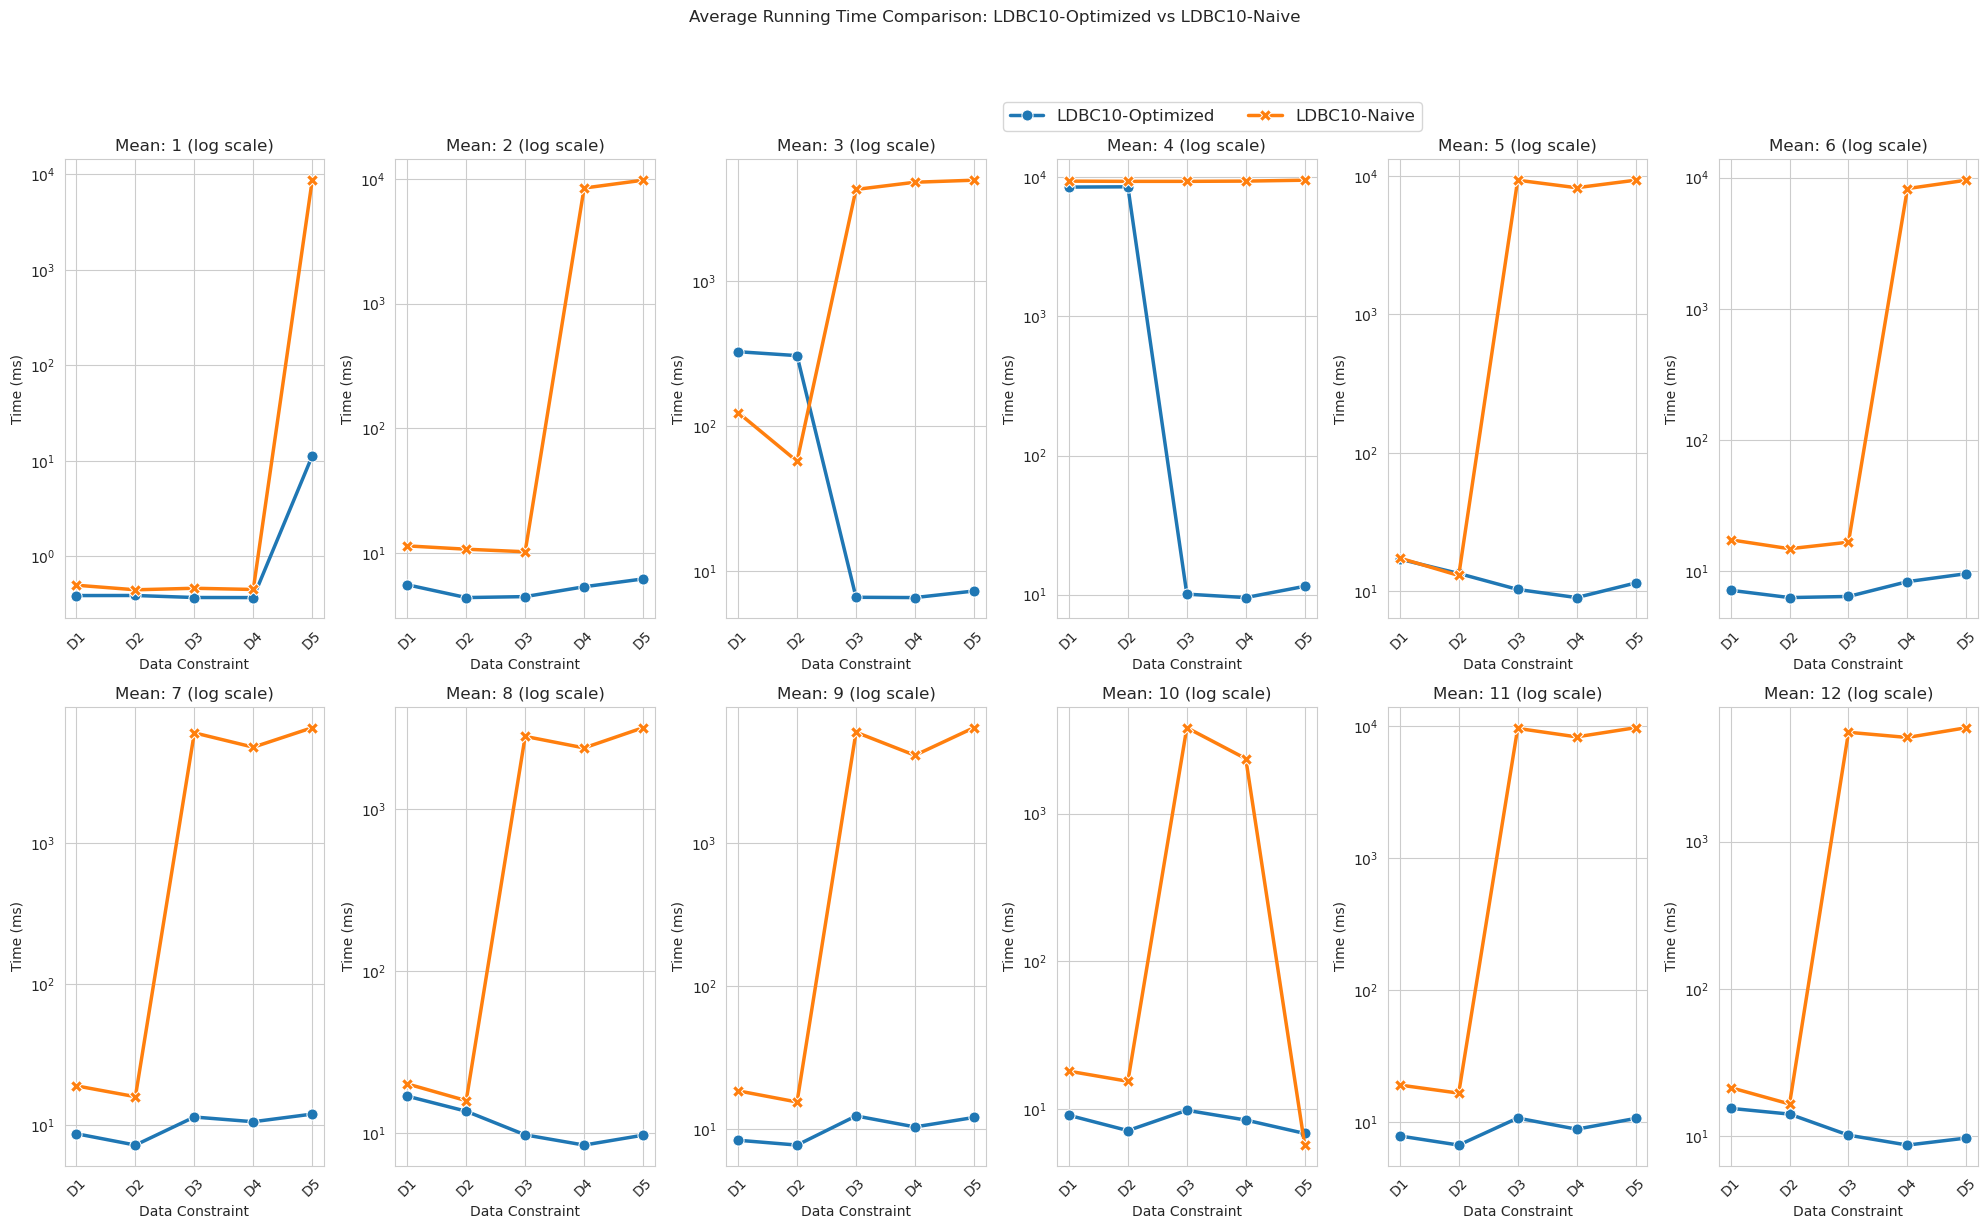

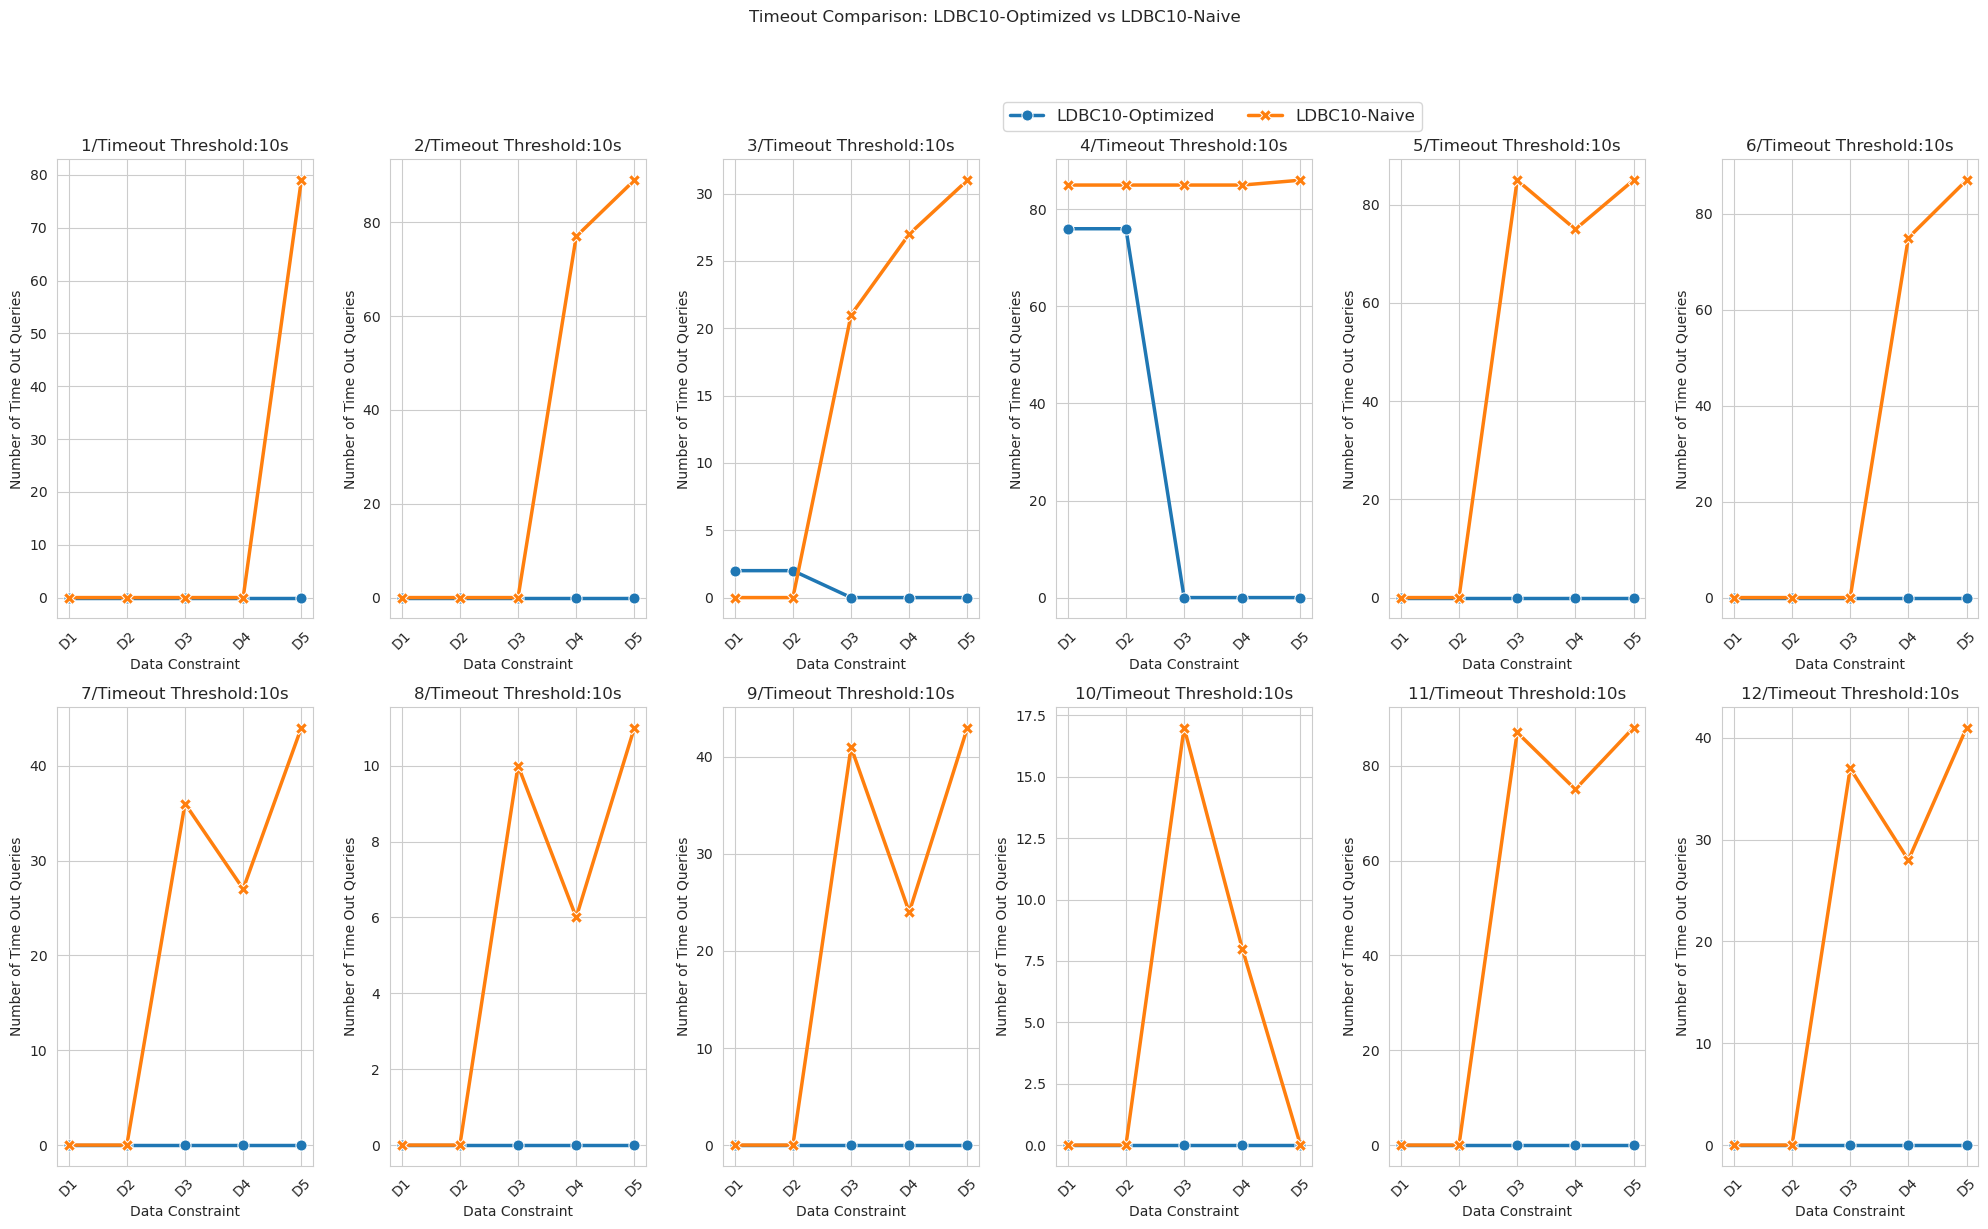

In [2]:
plot_compare("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", "LDBC10", 10, True)

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

def plot_boxplot_with_timeout(path, path2, ds, name1="Optimized", name2="Naive", timeout=10, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data for box plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value,
                'IsTimeout': (value / 1000) > timeout
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(24, 8*rows))
    axes = axes.flatten()  # Flatten for easier indexing
    sns.set_style("whitegrid")

    # Get current font sizes to calculate double size
    current_fontsize = plt.rcParams['font.size']
    double_fontsize = current_fontsize * 2

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = axes[idx-1]
        query_df = df[df['Query'] == f"Q{query}"]
        if query_df.empty:
            ax.set_title(f"No data for Q{query-1}", fontsize=double_fontsize)
            continue
        
        # Create box plots
        boxplot = sns.boxplot(data=query_df, x='Data Constraint', y='Time', 
                             hue='Dataset', ax=ax, showfliers=False,
                             palette=['skyblue', 'lightcoral'])
        
        # Add timeout threshold line
        timeout_ms = timeout * 1000  # Convert seconds to milliseconds
        ax.axhline(y=timeout_ms, color='red', linestyle='--', linewidth=3, 
                  alpha=0.8, label=f'Timeout Threshold ({timeout}s)')
        
        # Calculate and display timeout statistics with larger font
        for dataset_name in [name1, name2]:
            dataset_timeout_df = query_df[(query_df['Dataset'] == dataset_name) & (query_df['IsTimeout'])]
            timeout_count = len(dataset_timeout_df)
            total_count = len(query_df[query_df['Dataset'] == dataset_name])
            timeout_percentage = (timeout_count / total_count * 100) if total_count > 0 else 0
            
            # Add timeout count annotation with larger font
            color = 'blue' if dataset_name == name1 else 'red'
            ax.text(0.02, 0.85 - (0.1 * (list([name1, name2]).index(dataset_name))), 
                   f'{dataset_name}: {timeout_count}/{total_count} ({timeout_percentage:.1f}%)',
                   transform=ax.transAxes, verticalalignment='top',
                   color=color, fontweight='bold', fontsize=double_fontsize * 0.7)
        
        # Set titles and labels with larger font
        ax.set_title(f"Q{query-1}", fontweight='bold', fontsize=double_fontsize)
        ax.set_xlabel("", fontsize=double_fontsize)
        ax.set_ylabel("Time (ms)", fontsize=double_fontsize)
        
        # Increase tick label size
        ax.tick_params(axis='x', labelsize=double_fontsize * 0.8)
        ax.tick_params(axis='y', labelsize=double_fontsize * 0.8)
        
        plt.setp(ax.get_xticklabels(), rotation=45)
        
        # Check for log scale
        max_time_val = query_df['Time'].max()
        min_time_val = query_df[query_df['Time'] > 0]['Time'].min()  # Exclude zeros
        if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Q{query-1} (log scale)", fontweight='bold', fontsize=double_fontsize)
        else:
            # Reduce distance between y-axis ticks by half for linear scale
            y_min, y_max = ax.get_ylim()
            current_ticks = ax.get_yticks()
            
            if len(current_ticks) > 1:
                current_spacing = current_ticks[1] - current_ticks[0]
                new_spacing = current_spacing / 2
                
                # Make sure we don't create too many ticks
                max_ticks = 20
                num_ticks = int((y_max - y_min) / new_spacing) + 1
                
                if num_ticks <= max_ticks:
                    new_ticks = np.arange(round(y_min / new_spacing) * new_spacing, 
                                         round(y_max / new_spacing) * new_spacing + new_spacing, 
                                         new_spacing)
                    ax.set_yticks(new_ticks)
                else:
                    # Use automatic locator if too many ticks would be created
                    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=max_ticks))

        # Remove individual legends (we'll create a global one)
        if ax.get_legend():
            ax.get_legend().remove()
    
    # Remove empty subplots if any
    for idx in range(num_queries, len(axes)):
        fig.delaxes(axes[idx])
    
    # Create comprehensive legend with much larger text
    legend_elements = [
        Patch(facecolor='skyblue', label=f'{name1}'),
        Patch(facecolor='lightcoral', label=f'{name2}'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=3, 
               label=f'Timeout Threshold ({timeout}s)')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, 1.0), ncol=3, 
               fontsize=double_fontsize * 1.2,  # Even larger for legend
               frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f'figure/{ds}-{name1}-vs-{name2}-boxplot-timeout.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

# Optional: Keep the original function for comparison
def plot_combined_comparison(path, path2, name1, name2, timeout, log_scale=True):
    # Original implementation here
    pass

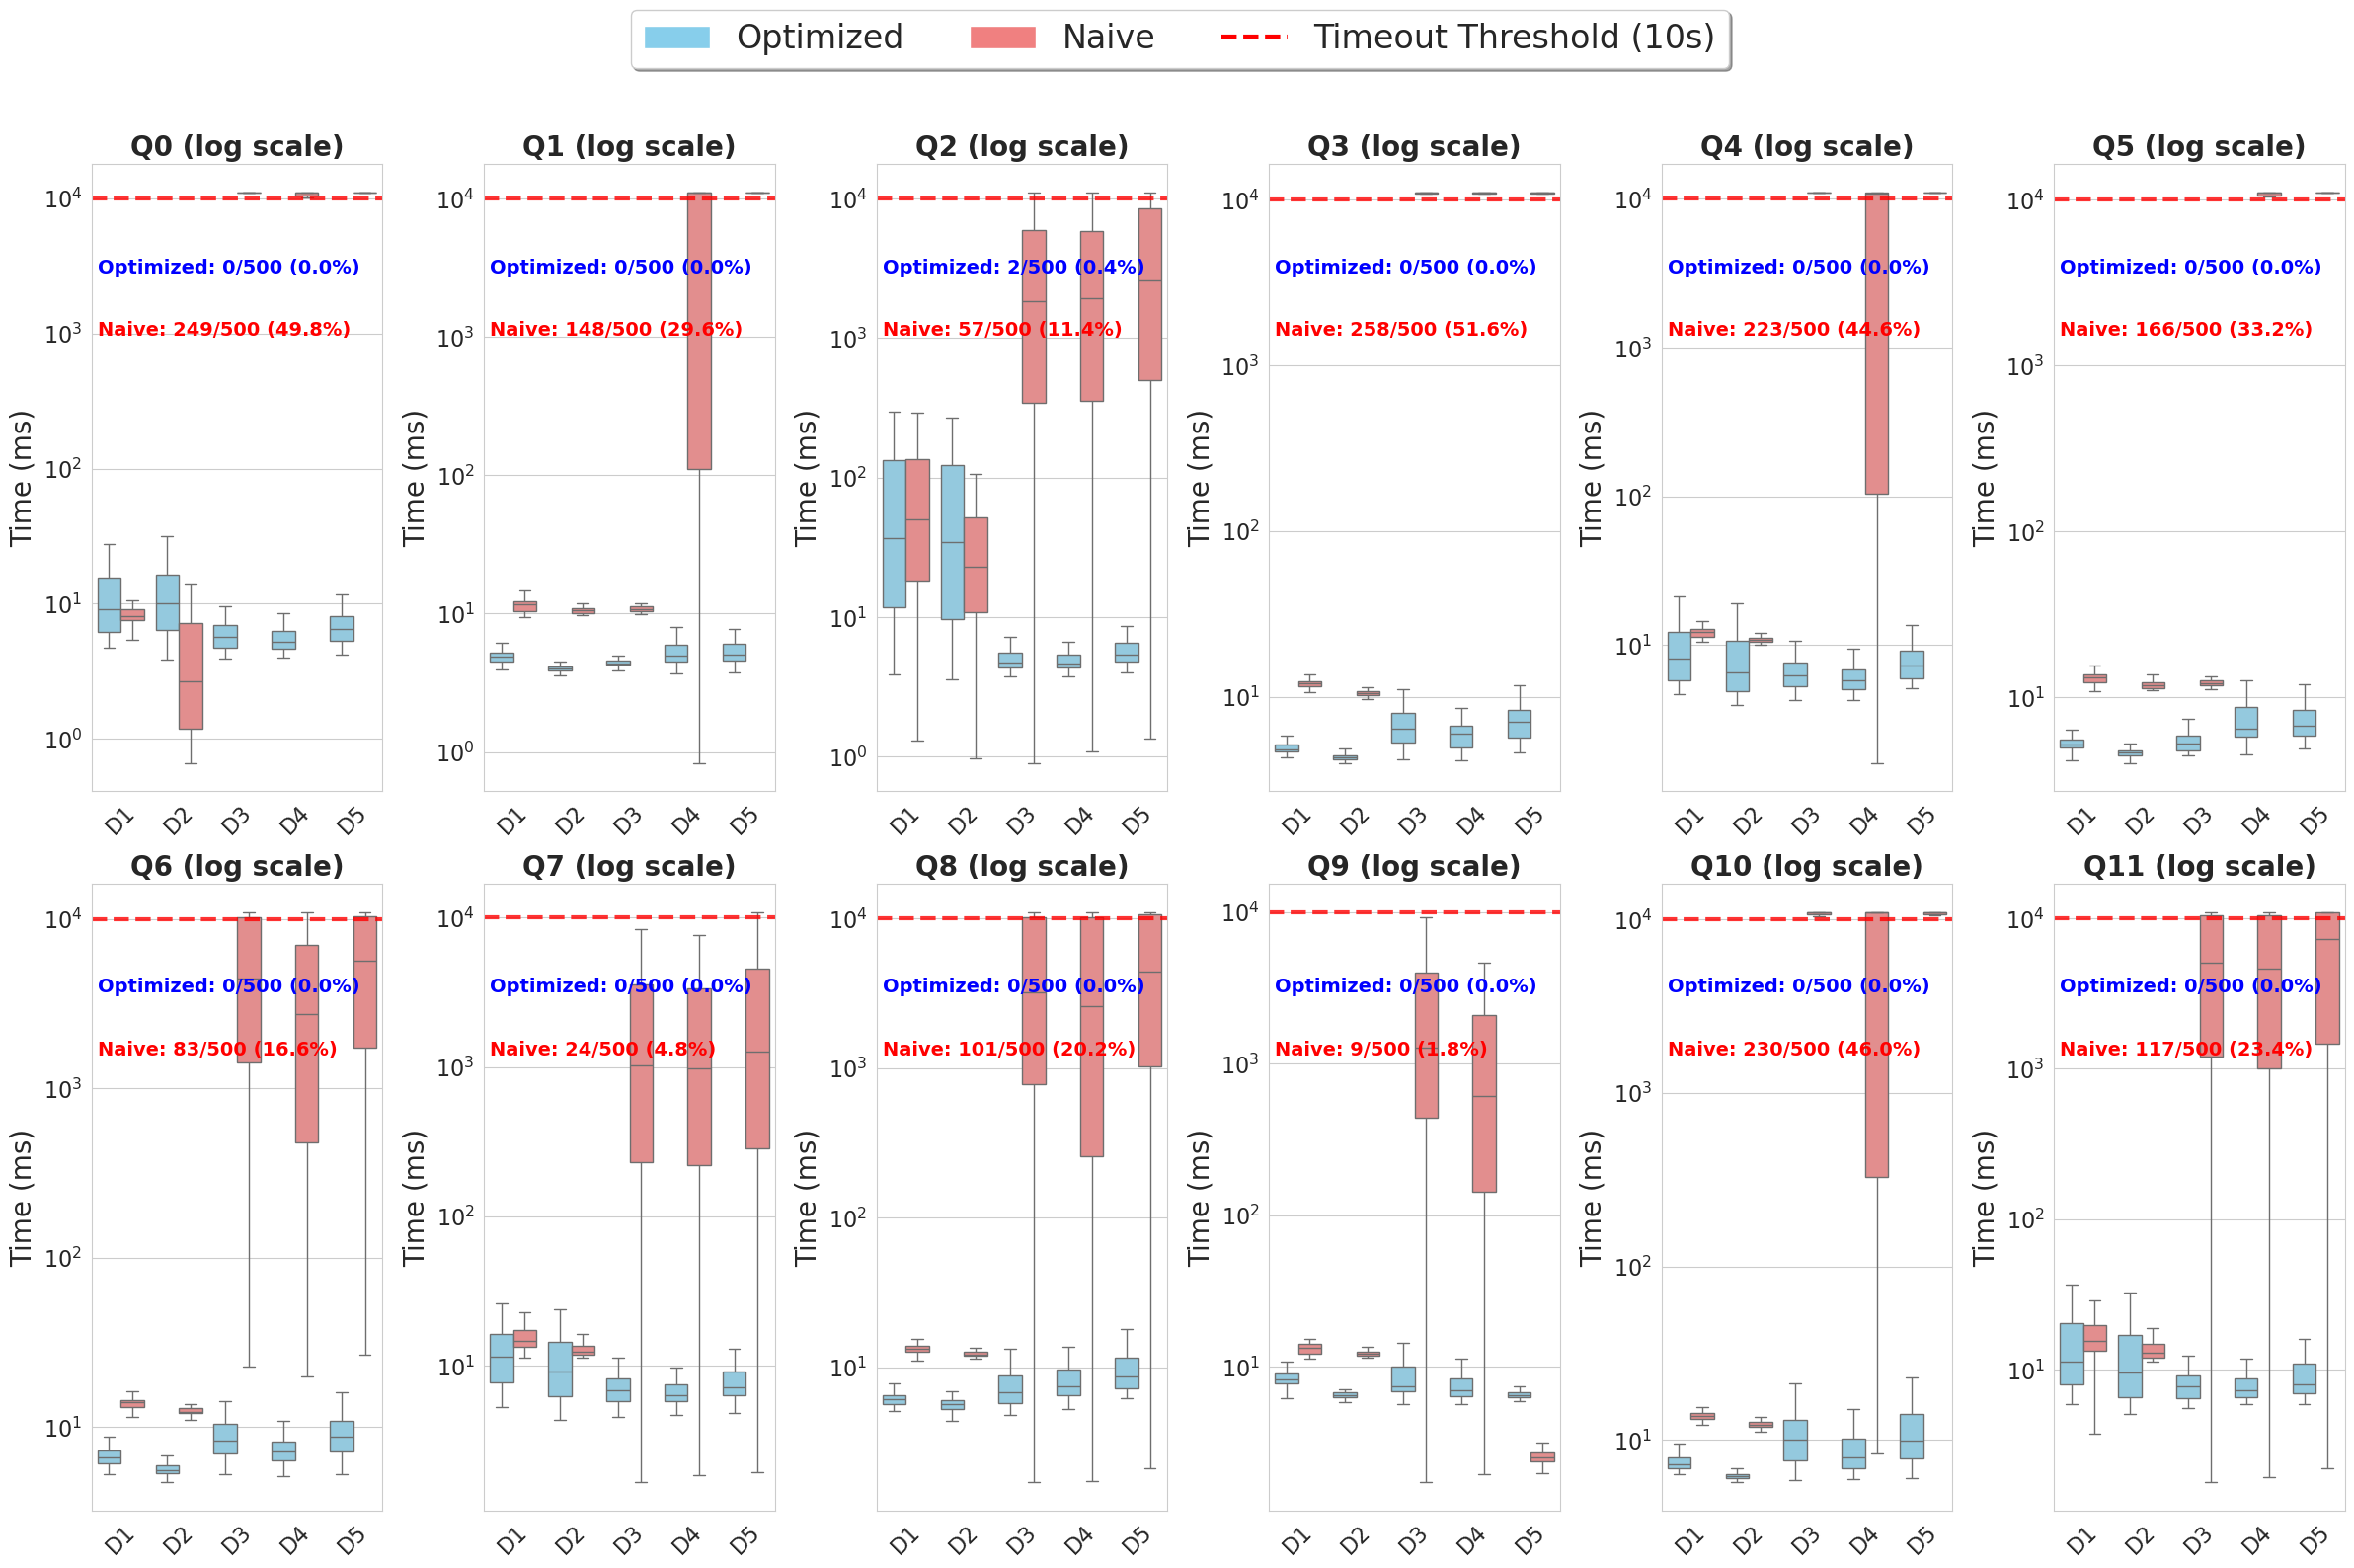

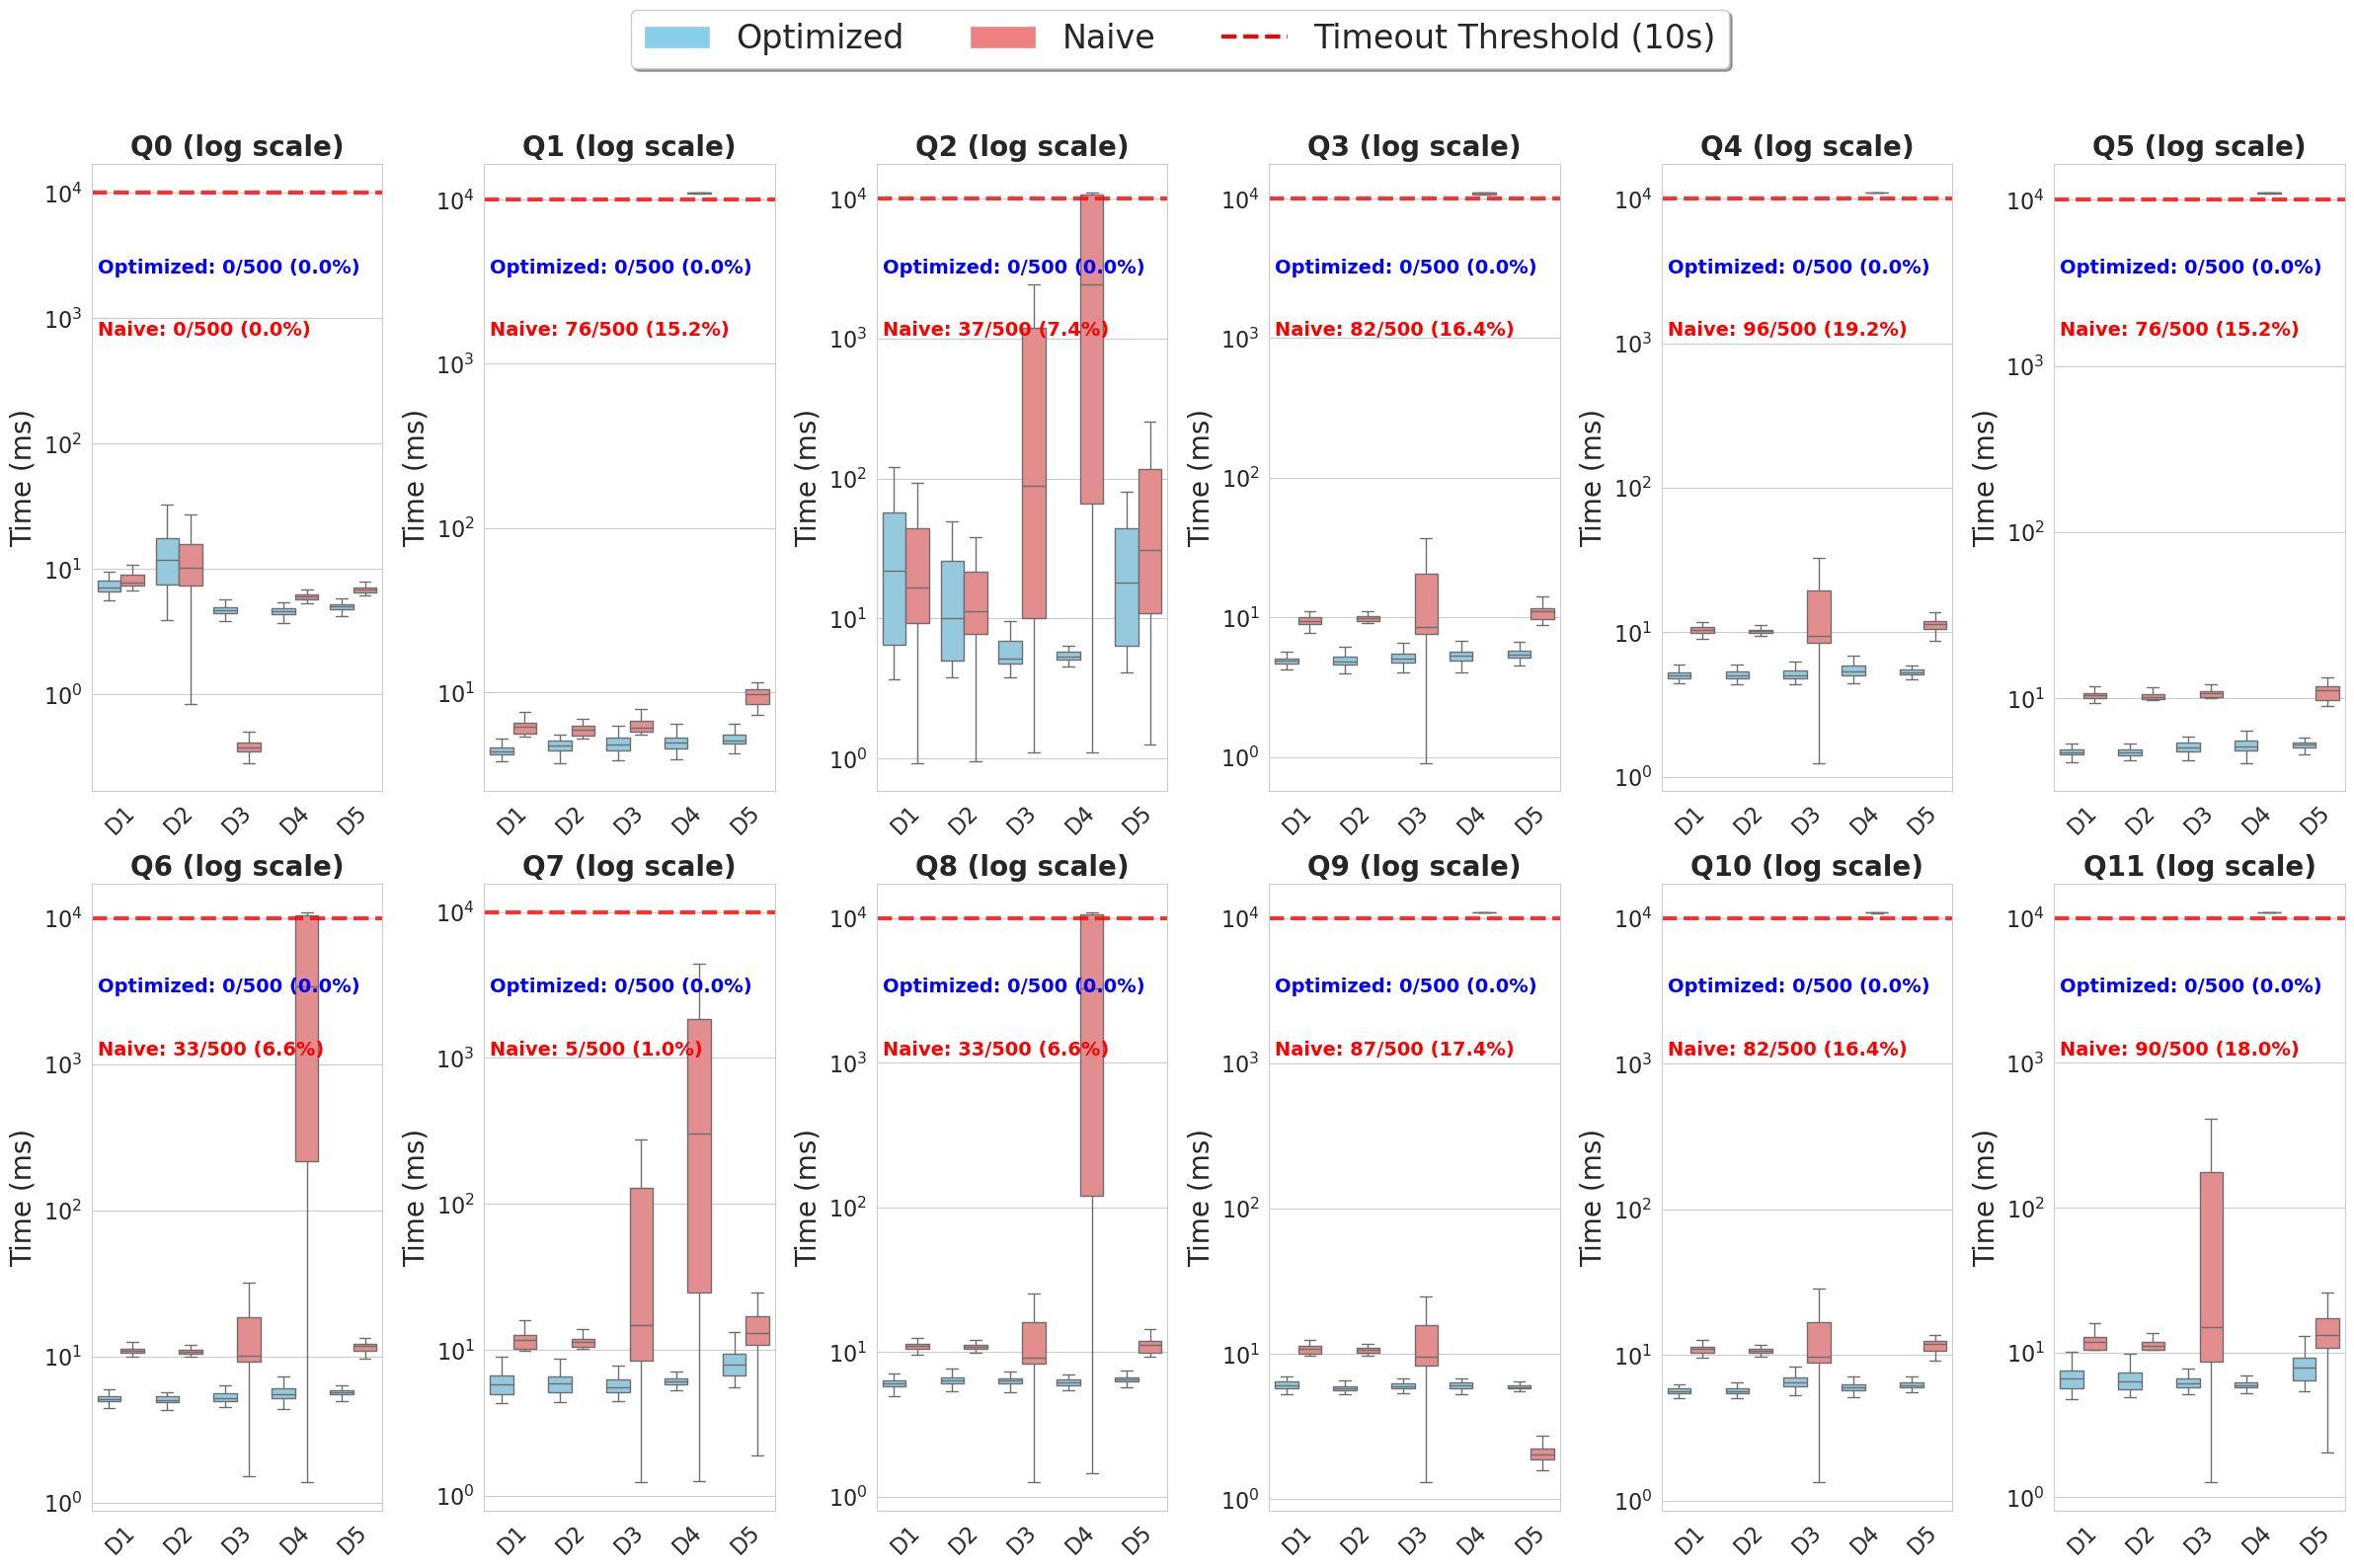

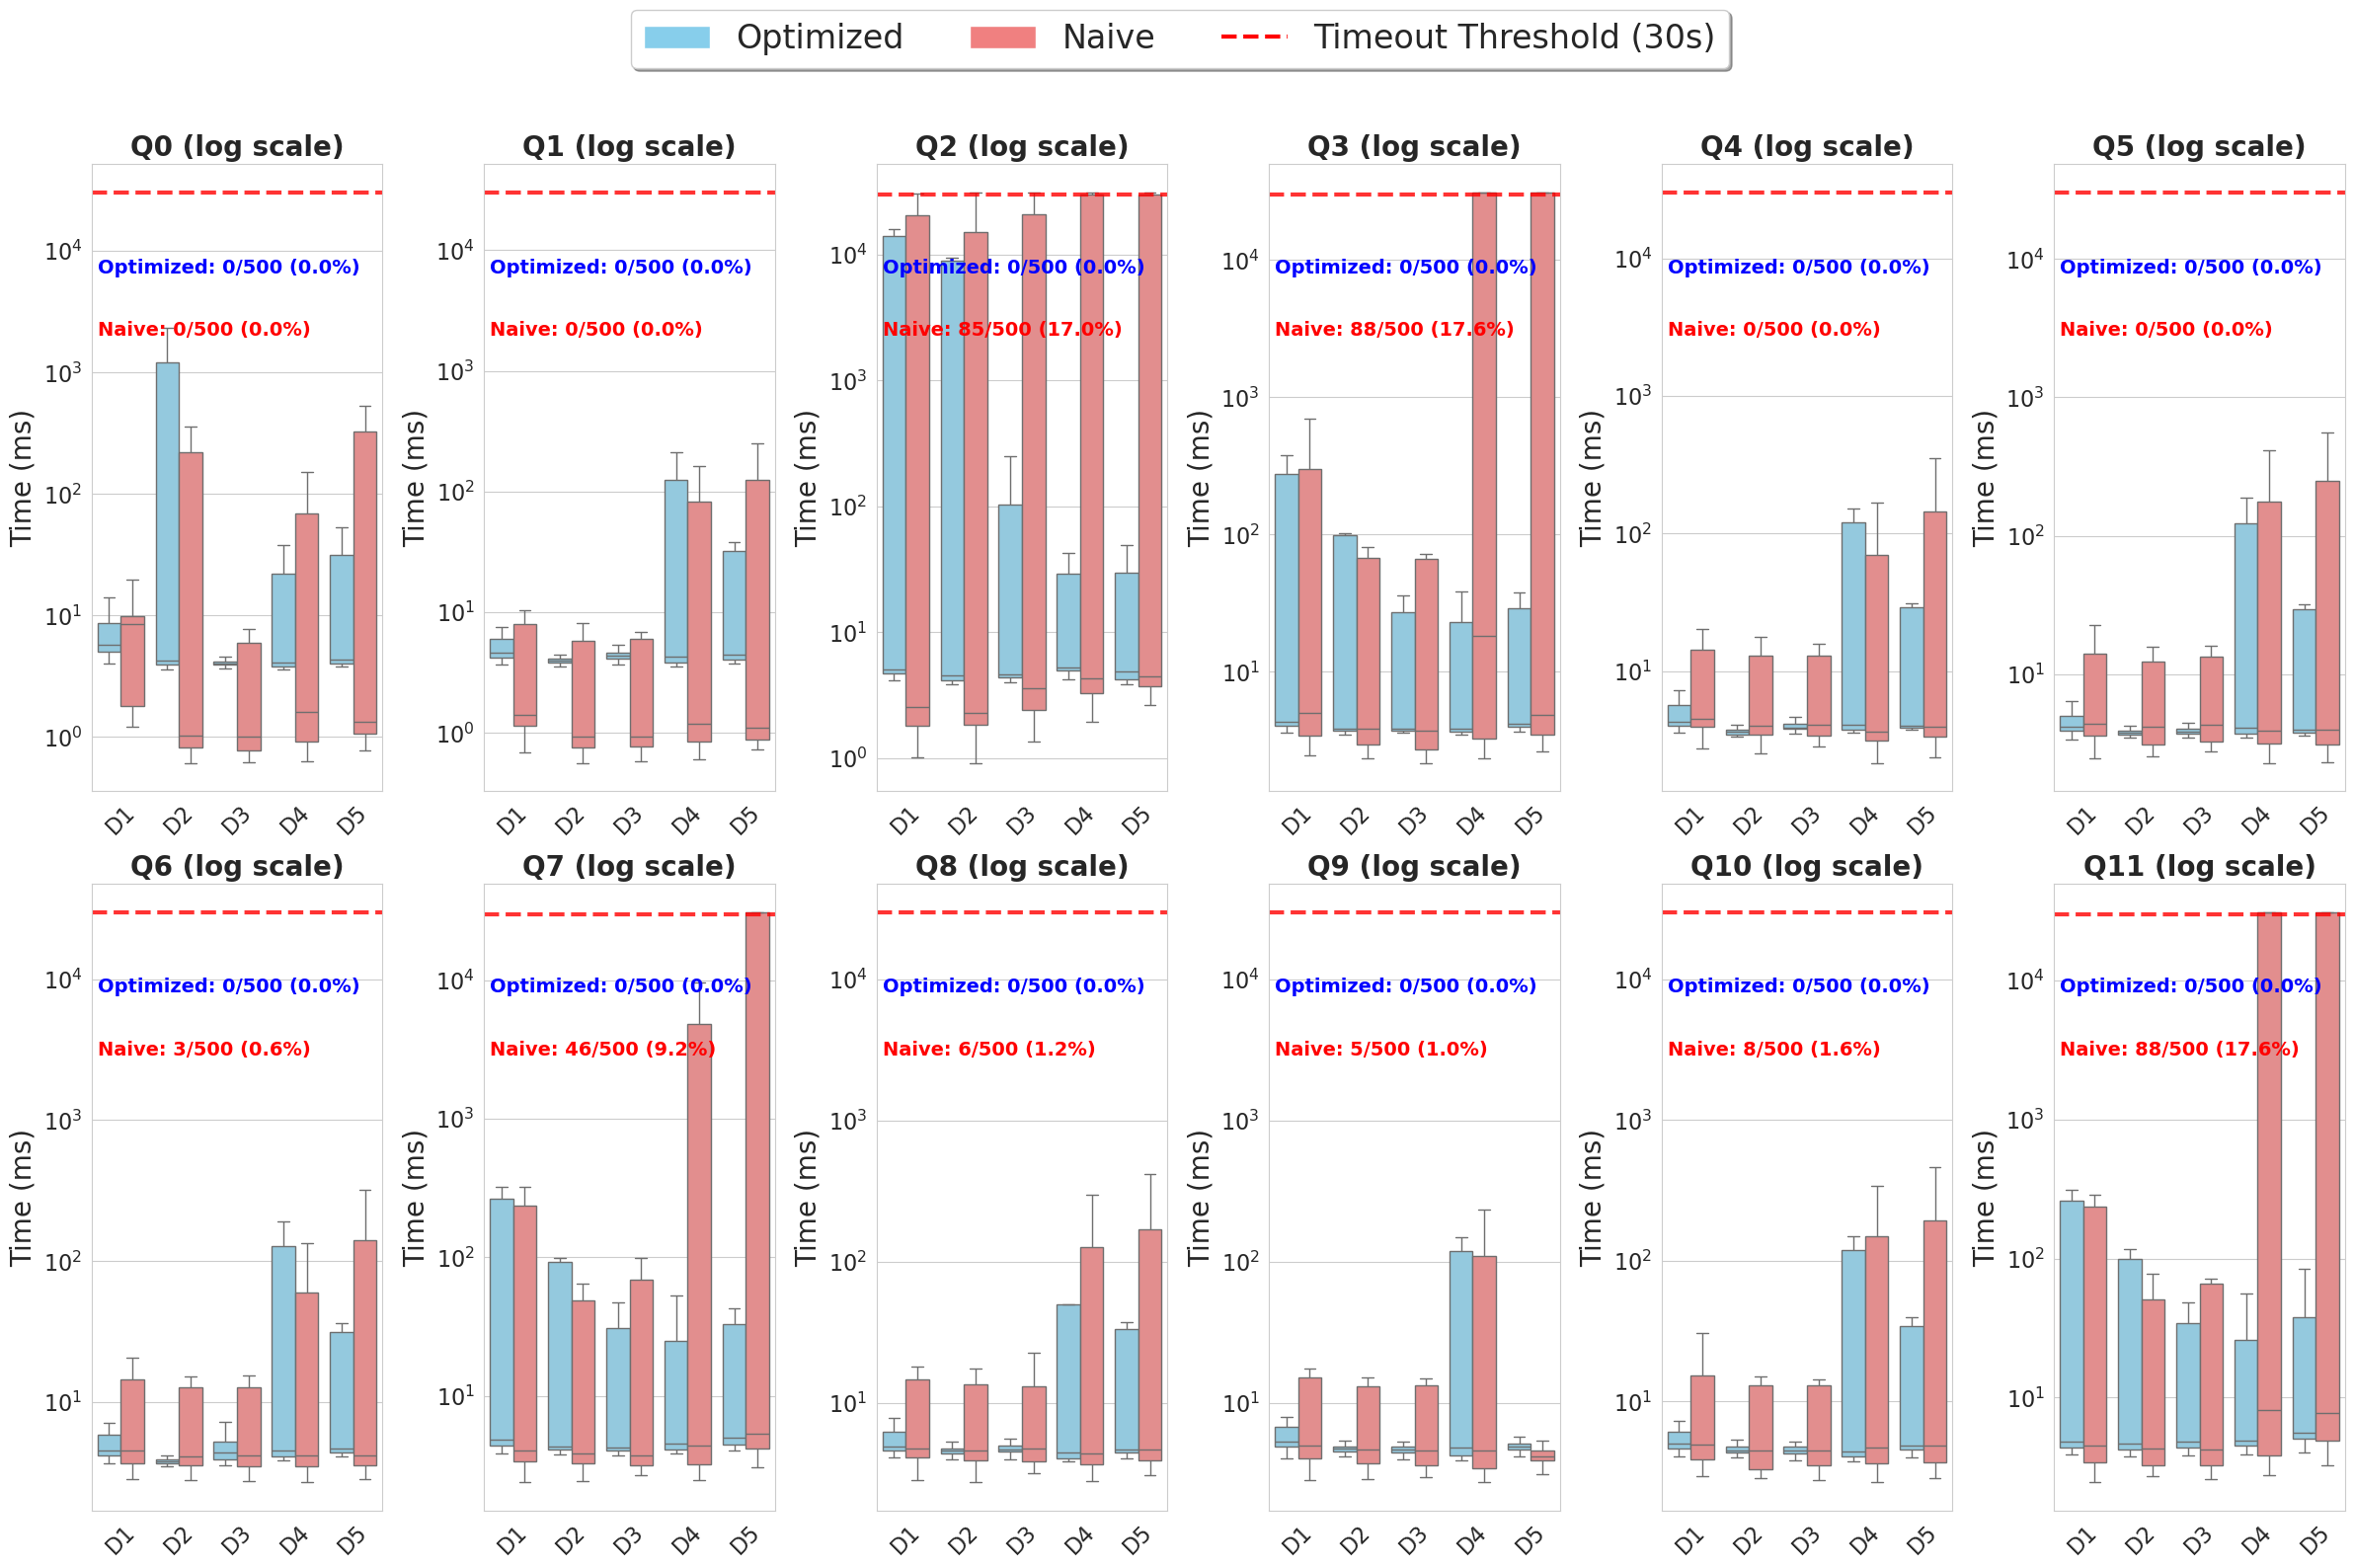

In [6]:
plot_boxplot_with_timeout("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", ds="LDBC10", timeout=10)
plot_boxplot_with_timeout("pokec/pokec_statistic.pkl", "pokec-naive/pokec_naive_statistic.pkl", ds="Pokec", timeout=10)
plot_boxplot_with_timeout("telecom/telecom_statistic.pkl", "telecom-naive/telecom_naive_statistic.pkl", ds="Telecom", timeout=30)

In [78]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

def plot_single_dataset_boxplot(path, ds, name="Dataset", log_scale=True):
    # Load the dataset
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    # Process the dataset
    data_groups = []
    for i in range(12):  # Q1-Q12
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            data_groups.append((f"Q{i+1}", dtype, name, values))
            id += 1

    # Prepare data for box plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create a single large figure
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.set_style("whitegrid")

    # Get current font sizes to calculate double size
    current_fontsize = plt.rcParams['font.size']
    double_fontsize = current_fontsize * 3

    # Create box plots for all queries (Q as x-axis)
    boxplot = sns.boxplot(data=df, x='Query', y='Time', 
                         hue='Data Constraint', ax=ax, showfliers=False,
                         palette='viridis', dodge=True)
    
    # Set titles and labels with larger font
    # ax.set_title(f"Runtime Distribution - {ds}", fontweight='bold', fontsize=double_fontsize * 1.2)
    ax.set_xlabel("")
    ax.set_ylabel("Time (ms)", fontsize=double_fontsize)
    
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=double_fontsize * 0.9)
    ax.tick_params(axis='y', labelsize=double_fontsize * 0.9)
    
    # plt.setp(ax.get_xticklabels())
    
    # Check for log scale
    max_time_val = df['Time'].max()
    min_time_val = df[df['Time'] > 0]['Time'].min()  # Exclude zeros
    if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 1000:
        ax.set_yscale("log")
        # ax.set_title(f"Runtime Distribution - {ds} (log scale)", fontweight='bold', fontsize=double_fontsize * 1.2)
    else:
        # Reduce distance between y-axis ticks by half for linear scale
        y_min, y_max = ax.get_ylim()
        current_ticks = ax.get_yticks()
        
        if len(current_ticks) > 1:
            current_spacing = current_ticks[1] - current_ticks[0]
            new_spacing = current_spacing / 2
            
            # Make sure we don't create too many ticks
            max_ticks = 20
            num_ticks = int((y_max - y_min) / new_spacing) + 1
            
            if num_ticks <= max_ticks:
                new_ticks = np.arange(round(y_min / new_spacing) * new_spacing, 
                                     round(y_max / new_spacing) * new_spacing + new_spacing, 
                                     new_spacing)
                ax.set_yticks(new_ticks)
            else:
                # Use automatic locator if too many ticks would be created
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=max_ticks))

    # Create legend for data constraints only
    data_constraints = ["D1", "D2", "D3", "D4", "D5"]
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_constraints)))
    
    legend_elements = []
    for constraint, color in zip(data_constraints, colors):
        legend_elements.append(
            Patch(facecolor=color, label=f'{constraint}')
        )
    

    legend = ax.legend(handles=legend_elements, 
                      loc='upper center',  # Changed to upper right corner
                      bbox_to_anchor=(0.5, 1.2),  # Slightly inside the corner
                      ncol=5,  # Single column for corner placement
                      fontsize=double_fontsize ,  # Even larger text for legend
                      frameon=True, 
                      fancybox=True, 
                      shadow=True,
                      title="Data Constraints", 
                      title_fontsize=double_fontsize  )  # Larger title
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig(f'figure/{ds}-query-x-axis-boxplot.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()


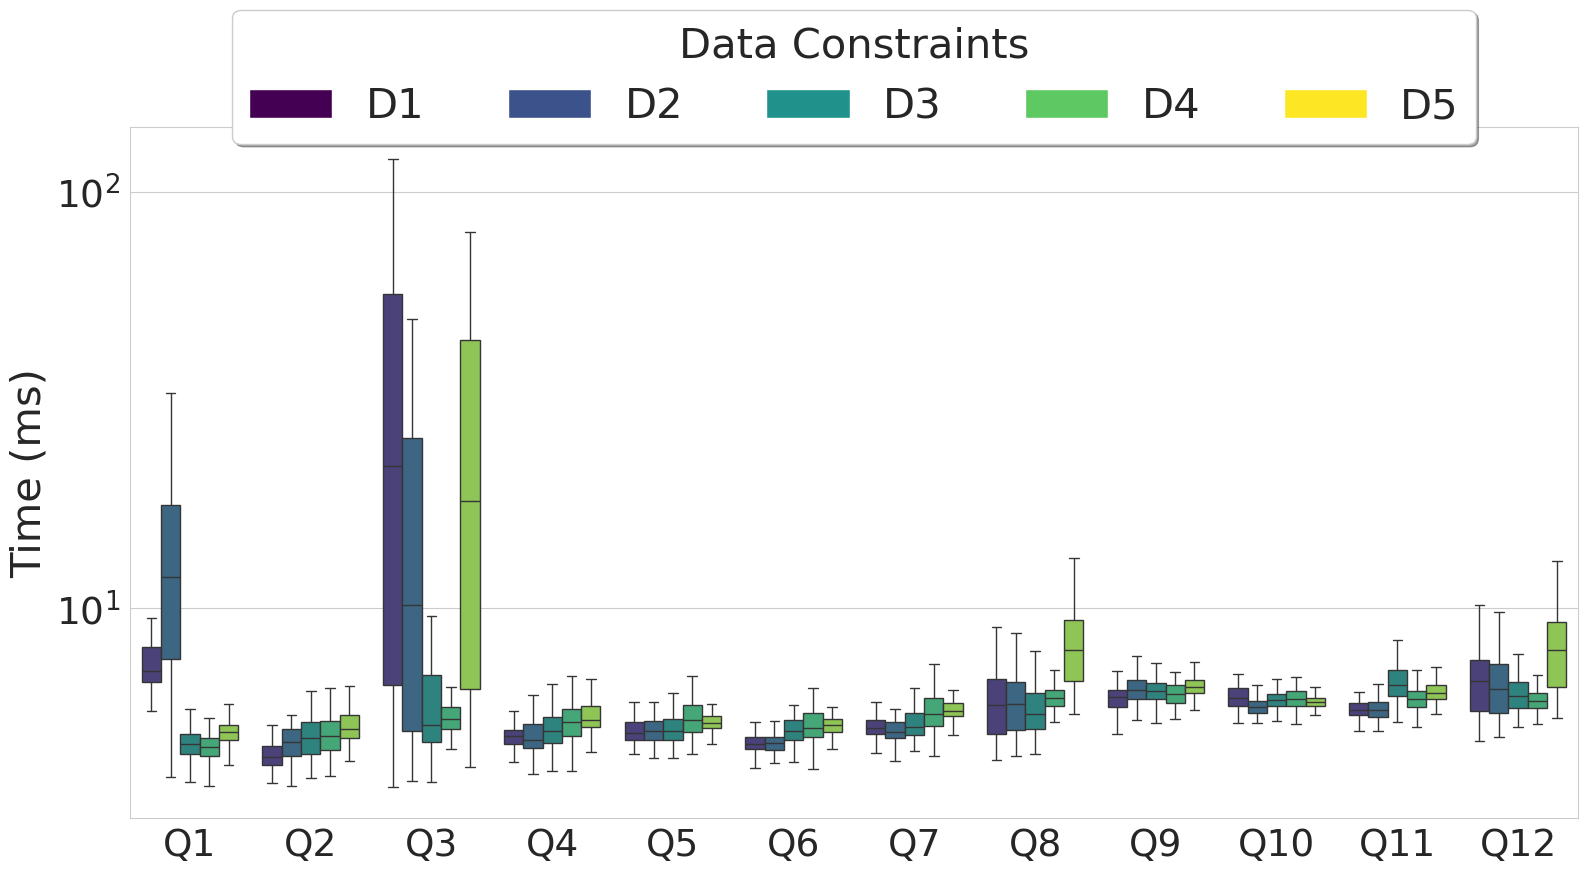

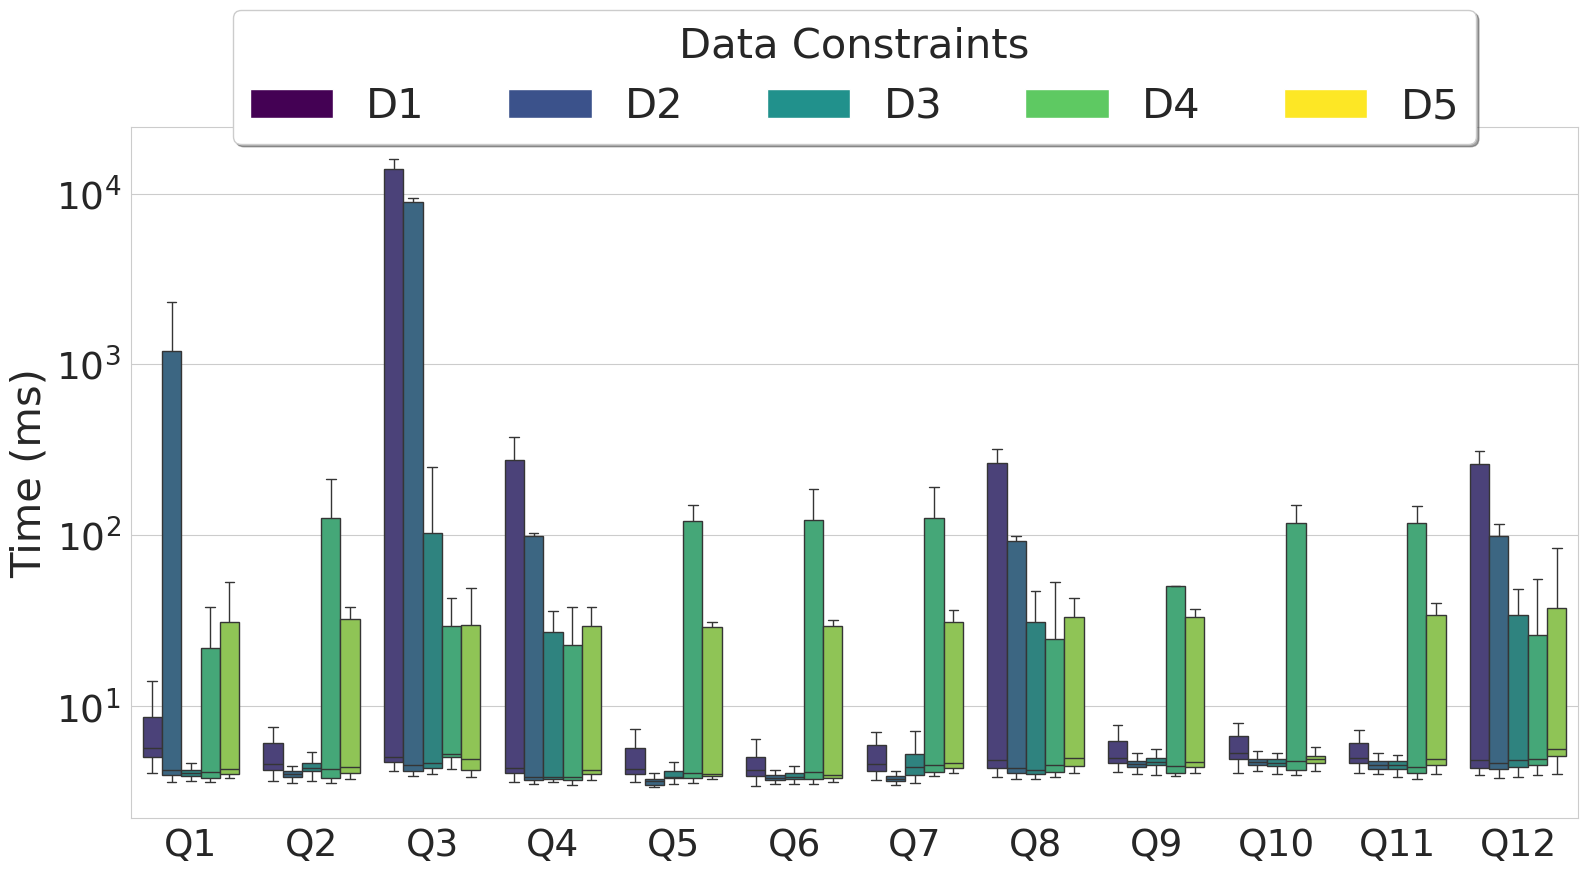

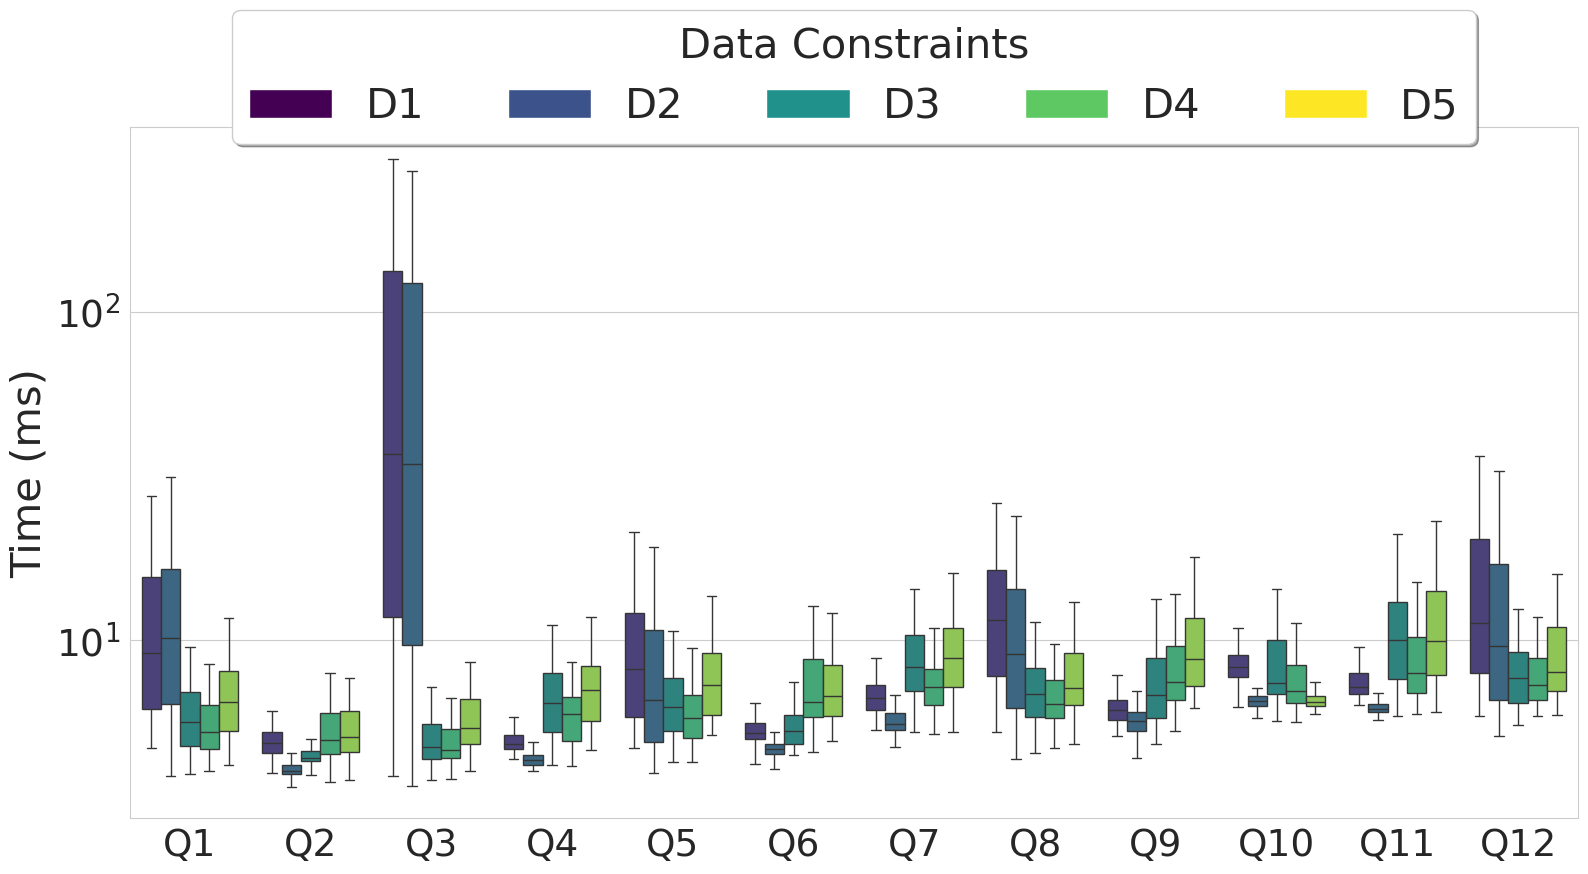

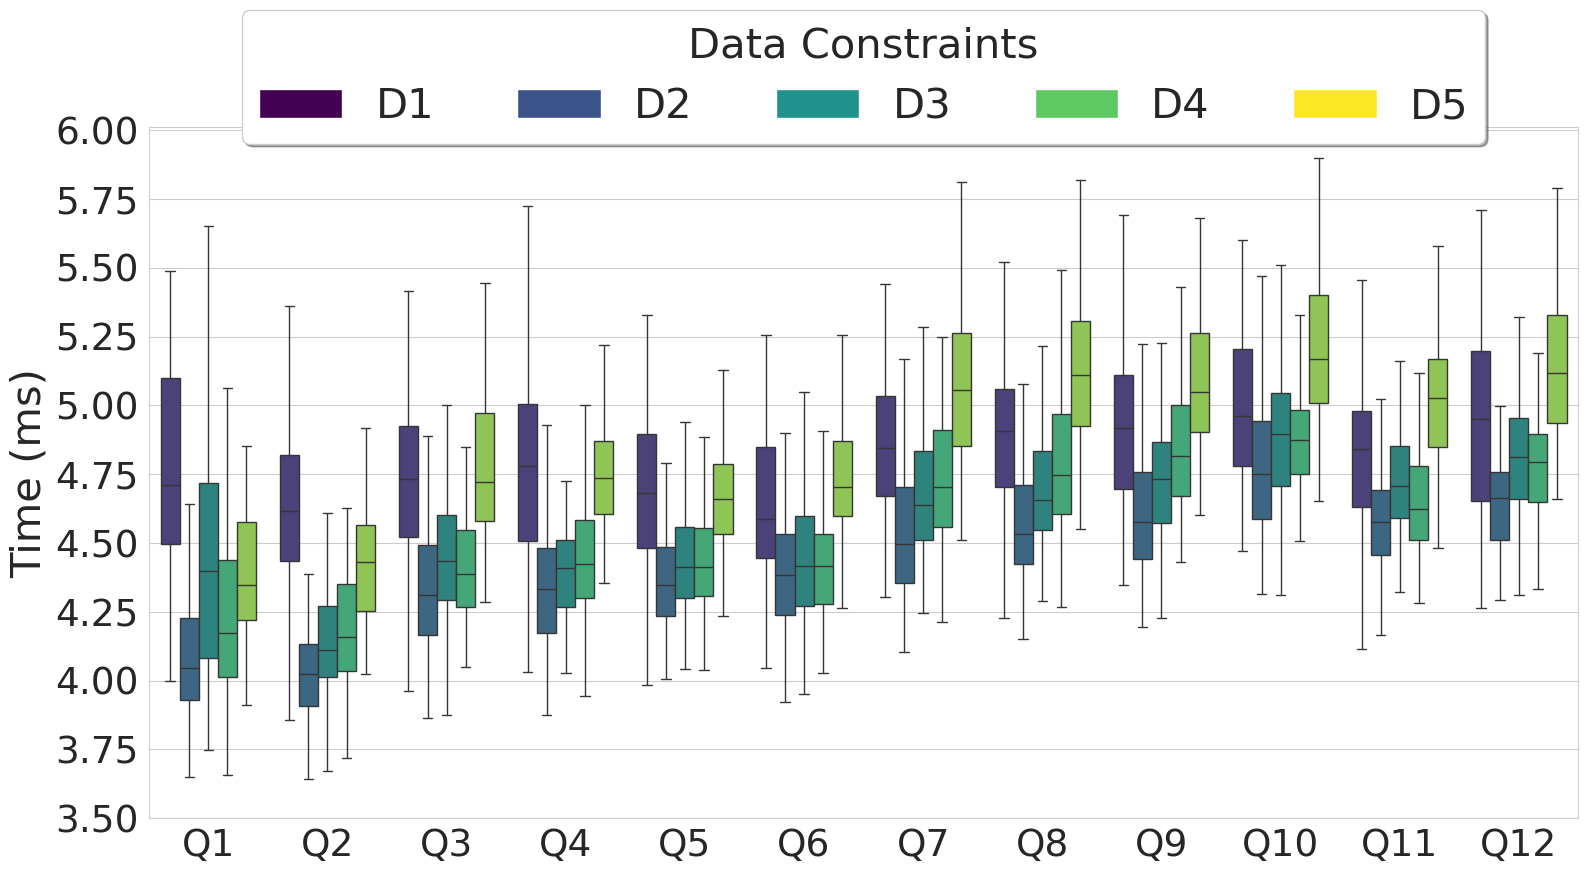

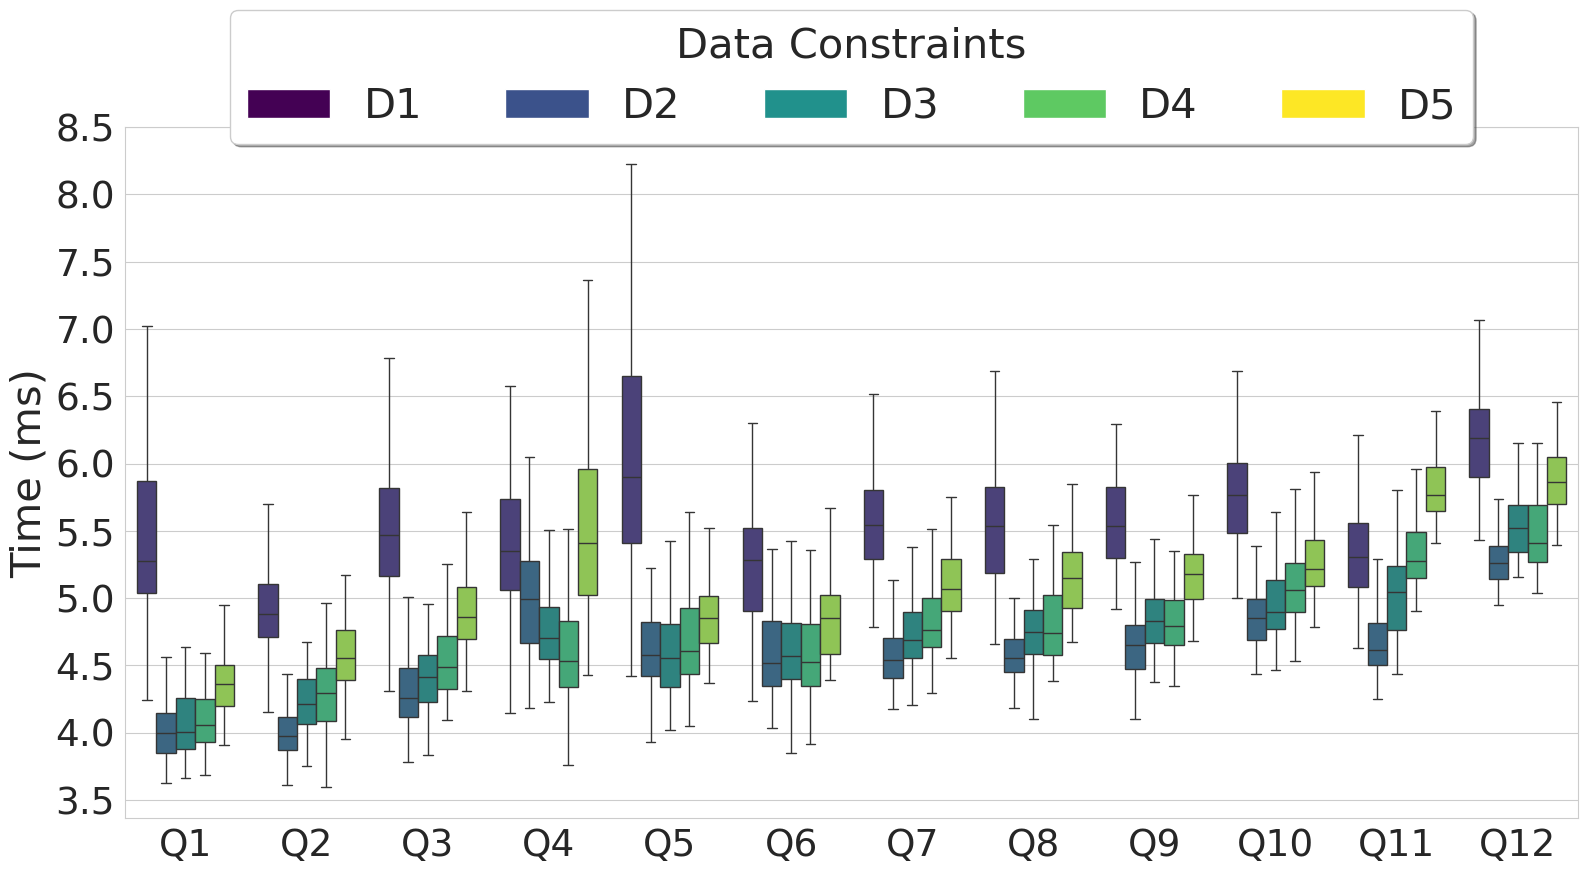

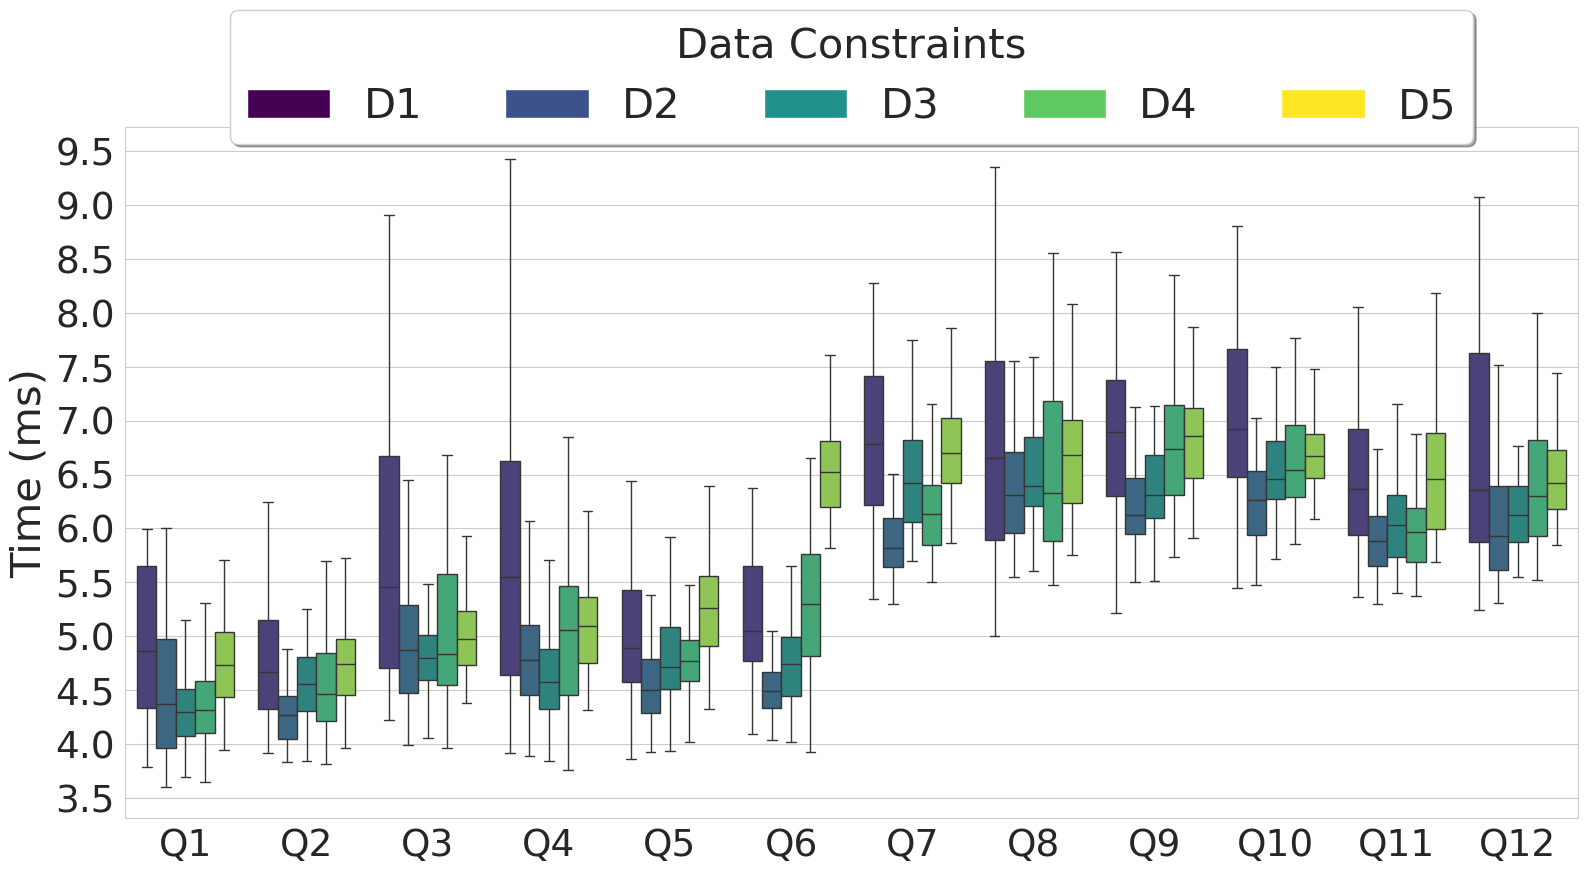

In [79]:
plot_single_dataset_boxplot("pokec/pokec_statistic.pkl", ds="Pokec")
plot_single_dataset_boxplot("telecom/telecom_statistic.pkl", ds="Telecom")
plot_single_dataset_boxplot("ldbc10/ldbc10_statistic.pkl", ds="LDBC10")
plot_single_dataset_boxplot("ldbc01/ldbc01_statistic.pkl", ds="LDBC01")
plot_single_dataset_boxplot("icij-leak/icij_leak_static.pkl", ds="ICIJ")
plot_single_dataset_boxplot("paradise/icij_paradise_statistic.pkl", ds="Paradise")





In [41]:
optimized_paths = ["ldbc01/ldbc01_statistic.pkl", 
         "ldbc10/ldbc10_statistic.pkl", 
         "pokec/pokec_statistic.pkl",
         "telecom/telecom_statistic.pkl",
            "paradise/icij_paradise_statistic.pkl",
            "icij-leak/icij_leak_statistic.pkl"]
        
naive_paths = ["ldbc01-naive/ldbc01_naive_statistic.pkl", 
         "ldbc10-naive/ldbc10_naive_statistic.pkl", 
         "pokec-naive/pokec_naive_statistic.pkl",
         "telecom-naive/telecom_naive_statistic.pkl",
            "paradise-naive/icij_paradise_naive_statistic.pkl",
            "icij-leak-naive/icij_leak_naive_statistic.pkl"]

dataset_names = ["LDBC01", "LDBC10", "Pokec", "Telecom", "ICIJ-Paradise", "ICIJ-Leak"]


In [69]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_dataset_memory_comparison(optimized_paths, dataset_names, output_name, unit='MB'):
    """
    Plot memory usage comparison between datasets, merging all constraints and queries
    Focuses only on dataset differences
    
    Parameters:
    optimized_paths: list of file paths to optimized algorithm pickle files
    dataset_names: list of dataset names for comparison
    output_name: name for output file
    unit: memory unit ('B', 'KB', 'MB', 'GB')
    """
    
    # Load all datasets
    optimized_data = []
    
    for path in optimized_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            optimized_data.append(data)
    
    # Process memory usage - merge all constraints and queries
    dataset_stats = []
    
    for dataset_idx, (data, dataset_name) in enumerate(zip(optimized_data, dataset_names)):
        all_memory_values = []
        
        # Collect all memory values across all queries and constraints
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                
                # Extract memory usage data (third domain)
                memory_data = data[i*6 + id][3]  # Third domain contains memory usage
                all_memory_values.append(memory_data)
                id += 1
        
        # Convert to appropriate unit
        all_memory_values = np.array(all_memory_values)
        if unit == 'KB':
            all_memory_values = all_memory_values * 1024
        elif unit == 'MB':
            all_memory_values = all_memory_values 
        elif unit == 'GB':
            all_memory_values = all_memory_values / 1024 
        
        # Calculate statistics
        dataset_stats.append({
            'Dataset': dataset_name,
            'Max Memory': np.max(all_memory_values),
            'Average Memory': np.mean(all_memory_values),
            'Median Memory': np.median(all_memory_values),
            '95th Percentile': np.percentile(all_memory_values, 95),
            'Total Memory': np.sum(all_memory_values),
            'Memory Values': all_memory_values  # Store for boxplot
        })
    
    # Create DataFrame
    df = pd.DataFrame(dataset_stats)
    
    # Create figure with multiple subplots
    # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(1, 4, figsize=(16, 12))
    fig, ax1 = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Get current font sizes
    current_fontsize = plt.rcParams['font.size']
    larger_fontsize = current_fontsize * 2
    
    # Colors for datasets
    colors = plt.cm.Set3(np.linspace(0, 1, len(dataset_names)))
    
    # # Plot 1: Max Memory Usage
    bars1 = ax1.bar(range(len(df)), df['Max Memory'], color=colors, alpha=0.8)
    # ax1.set_title(f"Maximum Memory Usage ({unit})", fontsize=larger_fontsize, fontweight='bold')
    ax1.set_ylabel(f"Memory ({unit})", fontsize=larger_fontsize * 0.8)
    ax1.set_xticks(range(len(df)))
    ax1.set_xticklabels(df['Dataset'], ha='center', fontsize=larger_fontsize * 0.9)
    add_value_labels(ax1, bars1)
    
    # # Plot 2: Average Memory Usage
    # bars2 = ax2.bar(range(len(df)), df['Average Memory'], color=colors, alpha=0.8)
    # ax2.set_title(f"Average Memory Usage ({unit})", fontsize=larger_fontsize, fontweight='bold')
    # ax2.set_ylabel(f"Memory ({unit})", fontsize=larger_fontsize * 0.8)
    # ax2.set_xticks(range(len(df)))
    # ax2.set_xticklabels(df['Dataset'], rotation=45, ha='right', fontsize=larger_fontsize * 0.7)
    # add_value_labels(ax2, bars2)
    
    # # Plot 3: 95th Percentile Memory Usage
    # bars3 = ax3.bar(range(len(df)), df['95th Percentile'], color=colors, alpha=0.8)
    # ax3.set_title(f"95th Percentile Memory Usage ({unit})", fontsize=larger_fontsize, fontweight='bold')
    # ax3.set_ylabel(f"Memory ({unit})", fontsize=larger_fontsize * 0.8)
    # ax3.set_xticks(range(len(df)))
    # ax3.set_xticklabels(df['Dataset'], rotation=45, ha='right', fontsize=larger_fontsize * 0.7)
    # add_value_labels(ax3, bars3)
    
#    # Plot 4: Total Memory Usage
#     bars4 = ax4.bar(range(len(df)), df['Total Memory'], color=colors, alpha=0.8)
#     ax4 .set_title(f"Total Memory Usage ({unit})", fontsize=larger_fontsize, fontweight='bold')
#     ax4.set_ylabel(f"Memory ({unit})", fontsize=larger_fontsize * 0.8)
#     ax4.set_xticks(range(len(df)))
#     ax4.set_xticklabels(df['Dataset'], rotation=45, ha='right', fontsize=larger_fontsize * 0.7)
#     add_value_labels(ax4, bars4)
    
    # Main title
    # plt.suptitle("Memory Usage Comparison Across Datasets (All Constraints & Queries Merged)", 
    #             fontsize=larger_fontsize * 1.5, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save figure
    plt.savefig(f'figure/{output_name}-dataset-memory-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    # Additional: Box plot showing distribution
    
    return df

def add_value_labels(ax, bars):
    """Add value labels on top of bars"""
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=12)

def plot_memory_distribution_boxplot(dataset_stats, dataset_names, output_name, unit='MB'):
    """Plot boxplot showing memory distribution for each dataset"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data for boxplot
    memory_data = [stats['Memory Values'] for stats in dataset_stats]
    
    # Create boxplot
    boxplot = ax.boxplot(memory_data, labels=dataset_names, patch_artist=True)
    
    # Add colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(dataset_names)))
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    # Customize plot
    ax.set_title(f"Memory Usage Distribution Across Datasets ({unit})", 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel(f"Memory Usage ({unit})", fontsize=14)
    ax.set_xlabel("Datasets", fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figure/{output_name}-memory-distribution-boxplot.svg',
               format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

# Alternative: Simple single metric comparison
def plot_simple_memory_comparison(optimized_paths, dataset_names, output_name, unit='MB', metric='Max Memory'):
    """
    Simple comparison of one memory metric across datasets
    """
    # [Same data processing as above...]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get the selected metric values
    metric_values = [stats[metric] for stats in dataset_stats]
    
    # Plot bar chart
    bars = ax.bar(range(len(dataset_names)), metric_values, 
                 color=plt.cm.Set3(np.linspace(0, 1, len(dataset_names))), alpha=0.8)
    
    ax.set_title(f"{metric.replace('_', ' ').title()} ({unit})", fontsize=16, fontweight='bold')
    ax.set_ylabel(f"Memory ({unit})", fontsize=14)
    ax.set_xlabel("Datasets", fontsize=14)
    ax.set_xticks(range(len(dataset_names)))
    ax.set_xticklabels(dataset_names, rotation=45, ha='right')
    add_value_labels(ax, bars)
    
    plt.tight_layout()
    plt.savefig(f'figure/{output_name}-{metric.lower().replace(' ', '-')}-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

# Usage example:
# optimized_paths = ["opt1.pkl", "opt2.pkl", "opt3.pkl"]
# dataset_names = ["Dataset1", "Dataset2", "Dataset3"]
# stats_df = plot_dataset_memory_comparison(optimized_paths, dataset_names, "memory_comparison", unit='MB')

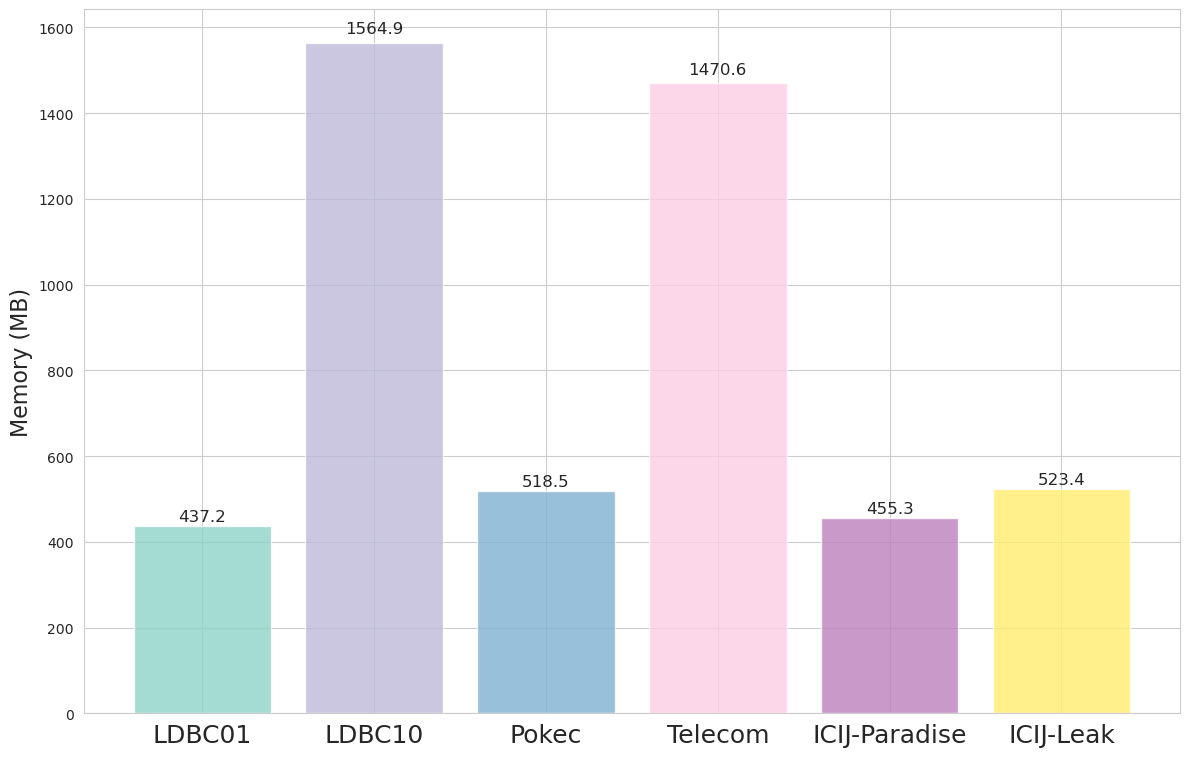

,Dataset,Max Memory,Average Memory,Median Memory,95th Percentile,Total Memory,Memory Values
0,LDBC01,437.187500,433.255208,434.375000,437.187500,25995.312500,"[424.21875, 424.53125, 424.53125, 425.0, 425.7..."
1,LDBC10,1564.867188,1540.957031,1551.429688,1564.867188,92457.421875,"[1463.4375, 1476.09375, 1476.09375, 1476.71875..."
2,Pokec,518.457031,507.479818,518.457031,518.457031,30448.789062,"[442.5, 457.65625, 457.8125, 458.59375, 458.75..."
3,Telecom,1470.625000,1329.831576,1469.972656,1469.997461,79789.894531,"[427.1875, 628.58203125, 628.58203125, 629.363..."
4,ICIJ-Paradise,455.312500,448.223958,449.609375,455.312500,26893.437500,"[434.375, 435.3125, 435.78125, 436.5625, 437.0..."
5,ICIJ-Leak,523.437500,515.046875,516.484375,523.437500,30902.812500,"[500.0, 500.9375, 501.25, 501.5625, 502.34375,..."


In [70]:
plot_dataset_memory_comparison(optimized_paths, dataset_names, "all-dataset-memory-distribution", unit='MB')

In [87]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_algorithm_comparison_by_dataset(optimized_paths, naive_paths, dataset_names, output_name, log_scale=True):
    """
    Plot comparison between optimized and naive algorithms across multiple datasets
    Split by dataset, with queries on x-axis and data constraints as lines
    
    Parameters:
    optimized_paths: list of file paths to optimized algorithm pickle files
    naive_paths: list of file paths to naive algorithm pickle files
    dataset_names: list of dataset names for subplots
    output_name: name for output file
    log_scale: whether to use log scale for y-axis
    """
    
    # Load all datasets
    optimized_data = []
    naive_data = []
    
    for path in optimized_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            optimized_data.append(data)
    
    for path in naive_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            naive_data.append(data)
    
    # Process all datasets
    plot_data = []
    
    # Process optimized algorithms
    for dataset_idx, (data, dataset_name) in enumerate(zip(optimized_data, dataset_names)):
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                values = list(map(lambda x: x, data[i*6 + id][2]))
                avg_time = np.mean(values)
                plot_data.append({
                    'Algorithm': 'Optimized',
                    'Dataset': dataset_name,
                    'Query': f"Q{i+1}",
                    'Data Constraint': dtype,
                    'Average Time': avg_time,
                    'Query Number': i + 1  # Numerical value for sorting
                })
                id += 1
    
    # Process naive algorithms
    for dataset_idx, (data, dataset_name) in enumerate(zip(naive_data, dataset_names)):
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                values = list(map(lambda x: x, data[i*6 + id][2]))
                avg_time = np.mean(values)
                plot_data.append({
                    'Algorithm': 'Naive',
                    'Dataset': dataset_name,
                    'Query': f"Q{i+1}",
                    'Data Constraint': dtype,
                    'Average Time': avg_time,
                    'Query Number': i + 1  # Numerical value for sorting
                })
                id += 1
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots for each dataset
    n_datasets = len(dataset_names)
    cols = min(3, n_datasets)  # Maximum 3 columns
    rows = (n_datasets + cols - 1) // cols  # Calculate required rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    
    # If only one dataset, make axes an array for consistent indexing
    if n_datasets == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    sns.set_style("whitegrid")
    
    # Get current font sizes to calculate larger size
    current_fontsize = plt.rcParams['font.size']
    larger_fontsize = current_fontsize * 2
    
    # Define colors for data constraints
    constraint_colors = {
        'D1': 'blue',
        'D2': 'green',
        'D3': 'red',
        'D4': 'purple',
        'D5': 'orange'
    }
    
    # Define line styles for algorithms
    algorithm_styles = {'Optimized': '-', 'Naive': '--'}
    
    # Define markers for better distinction
    markers = ['o', 's', 'D', '^', 'v']
    
    # Plot each dataset in a separate subplot
    for dataset_idx, dataset_name in enumerate(dataset_names):
        if dataset_idx >= len(axes):
            break
            
        ax = axes[dataset_idx]
        dataset_df = df[df['Dataset'] == dataset_name]
        
        # Plot each algorithm and data constraint combination
        for algorithm in ['Optimized', 'Naive']:
            algorithm_df = dataset_df[dataset_df['Algorithm'] == algorithm]
            
            for constraint_idx, constraint in enumerate(["D1", "D2", "D3", "D4", "D5"]):
                constraint_algorithm_df = algorithm_df[algorithm_df['Data Constraint'] == constraint]
                
                # Sort by query number
                constraint_algorithm_df = constraint_algorithm_df.sort_values('Query Number')
                
                # Plot line
                line = ax.plot(constraint_algorithm_df['Query'], constraint_algorithm_df['Average Time'],
                             color=constraint_colors[constraint],
                             linestyle=algorithm_styles[algorithm],
                             marker=markers[constraint_idx % len(markers)],
                             markersize=5,
                             linewidth=2.5,
                             label=f'{algorithm} - {constraint}' if dataset_idx == 0 else "",
                             alpha=0.8,
                             markevery=2)  # Show every 2nd marker to reduce clutter
        
        # Set subplot title and labels
        ax.set_title(f"{dataset_name}", fontsize=larger_fontsize, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Average Time (ms)", fontsize=larger_fontsize * 0.8)
        
        # Increase tick label size
        ax.tick_params(axis='x', labelsize=larger_fontsize * 0.7)
        ax.tick_params(axis='y', labelsize=larger_fontsize * 0.7)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Check for log scale
        # max_time_val = dataset_df['Average Time'].max()
        # min_time_val = dataset_df[dataset_df['Average Time'] > 0]['Average Time'].min()
        # if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 100:
        #     ax.set_yscale("log")
        #     ax.set_title(f"Dataset: {dataset_name} (Log Scale)", fontsize=larger_fontsize, fontweight='bold')
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        # # Add legend to first subplot only to avoid duplication
        # if dataset_idx == 0:
        #     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=larger_fontsize * 0.7)
    
    # Remove empty subplots if any
    for i in range(len(dataset_names), len(axes)):
        fig.delaxes(axes[i])
    
    # Create comprehensive legends outside the plots
    # Constraint legend elements
    constraint_legend_elements = []
    for constraint, color in constraint_colors.items():
        constraint_legend_elements.append(
            plt.Line2D([0], [0], color=color, linestyle='-', 
                      linewidth=3, marker='o', markersize=8, label=constraint)
        )
    
    # Algorithm legend elements
    algorithm_legend_elements = []
    for algorithm, style in algorithm_styles.items():
        algorithm_legend_elements.append(
            plt.Line2D([0], [0], color='black', linestyle=style,
                      linewidth=3, label=algorithm)
        )
    
    # Create legends
    legend1 = fig.legend(handles=constraint_legend_elements,
                        loc='upper center',
                        bbox_to_anchor=(0.3, 1.05),
                        ncol=5,
                        fontsize=larger_fontsize * 0.8,
                        title="Data Constraints",
                        title_fontsize=larger_fontsize)
    
    legend2 = fig.legend(handles=algorithm_legend_elements,
                        loc='upper center',
                        bbox_to_anchor=(0.7, 1.05),
                        ncol=2,
                        fontsize=larger_fontsize * 0.8,
                        title="Algorithms",
                        title_fontsize=larger_fontsize)
    
    # Main title
    # plt.suptitle("Algorithm Comparison: Optimized vs Naive by Dataset", 
    #             fontsize=larger_fontsize * 1.5, fontweight='bold', y=0.98)
    
    # Adjust layout to make room for legends
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save figure
    plt.savefig(f'figure/{output_name}-algorithm-comparison-by-dataset.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()



# Usage example:
# optimized_paths = ["opt1.pkl", "opt2.pkl", "opt3.pkl"]
# naive_paths = ["naive1.pkl", "naive2.pkl", "naive3.pkl"]
# dataset_names = ["Dataset1", "Dataset2", "Dataset3"]
# plot_algorithm_comparison_by_dataset(optimized_paths, naive_paths, dataset_names, "comparison", log_scale=True)

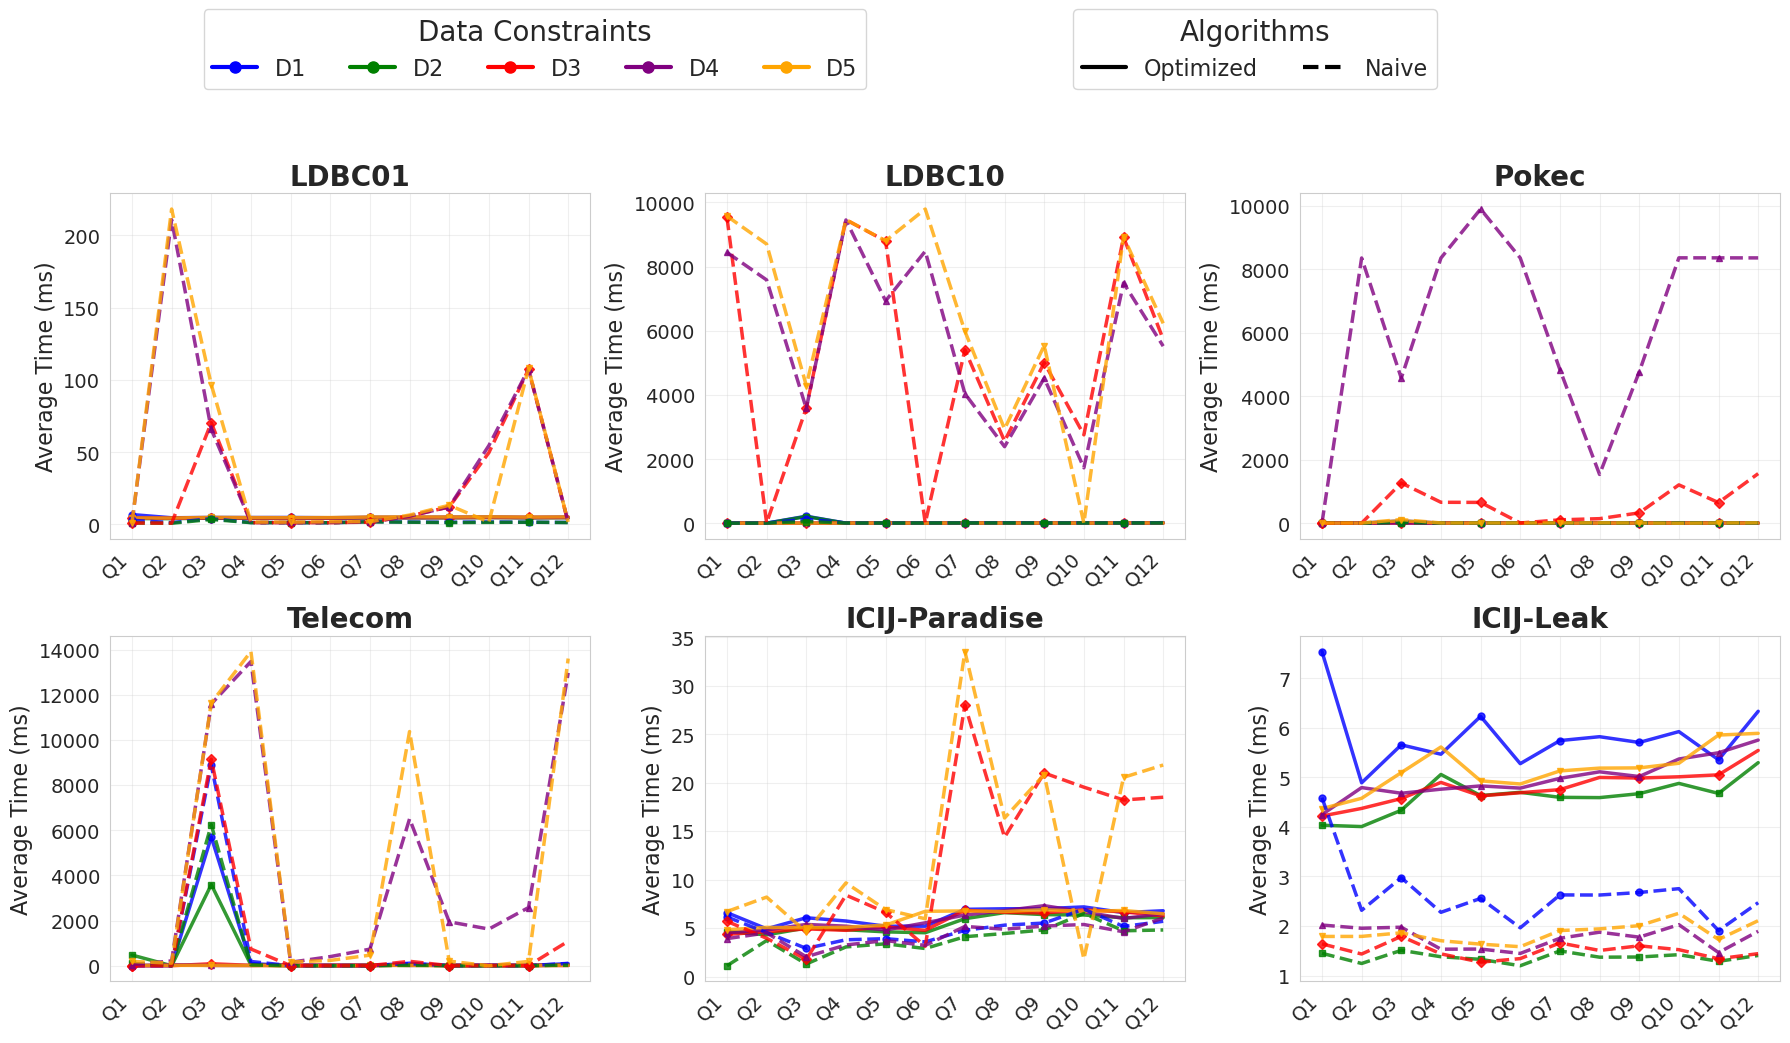

In [88]:
plot_algorithm_comparison_by_dataset(optimized_paths, naive_paths, dataset_names, "all-datasets", log_scale=True)

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from matplotlib.cm import get_cmap
import os

def slice_small_log(path):
    f = open(path, "rb+") 
    count = 0 
    res = []
    d = {}
    for qi in range(12):
        d[f"Q{qi+1}"] = {}
    for line in f:
        if "exploration_depth" in line.decode('utf-8'):
            res.append(int(line.decode('utf-8').split(":")[1].strip()))
    for i in range(12):
        for j in range(5):
            d[f"Q{i+1}"][f"D{j+1}"] = res[i*500 + j*100: i*500 + (j+1)*100]
    return d

def get_max_cardinality(d):
    """Extract maximum cardinality for each query and data constraint"""
    max_cardinalities = {}
    
    for q_key, q_data in d.items():
        max_cardinalities[q_key] = {}
        for d_key, d_data in q_data.items():
            if len(d_data) > 0:
                max_cardinalities[q_key][d_key] = np.max(d_data)
            else:
                max_cardinalities[q_key][d_key] = 0
    
    return max_cardinalities

def plot_max_cardinality_multiple_datasets(datasets_dict, dataset_names, log_scale=False):
    """
    Plot maximal cardinality of search trees across multiple datasets in subfigures
    
    Parameters:
    -----------
    datasets_dict : dict
        Dictionary where keys are dataset names and values are the data dictionaries
    dataset_names : list
        List of dataset names to include in the plot
    log_scale : bool
        Whether to use logarithmic scale for y-axis
    """
    
    # Create subplot grid - 2 rows, 3 columns for 6 datasets
    n_cols = 3
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten()
    
    # Data constraint colors (consistent across all subplots)
    # d_constraint_colors = get_cmap('Set2').colors
    
    constraint_colors = {
        'D1': 'blue',
        'D2': 'green',
        'D3': 'red',
        'D4': 'purple',
        'D5': 'orange'
    }
    # Get all data constraints from first dataset
    first_dataset = datasets_dict[dataset_names[0]]
    d_constraints = sorted(list(first_dataset[list(first_dataset.keys())[0]].keys()))

    current_fontsize = plt.rcParams['font.size']
    larger_fontsize = current_fontsize * 2
    
    # Plot each dataset in its own subplot
    for dataset_idx, dataset_name in enumerate(dataset_names):
        if dataset_idx >= len(axes):  # Safety check
            break
            
        if dataset_name not in datasets_dict:
            continue
            
        ax = axes[dataset_idx]
        dataset_data = datasets_dict[dataset_name]
        max_cardinalities = get_max_cardinality(dataset_data)
        
        # Get sorted query keys
        query_keys = sorted(max_cardinalities.keys(), key=lambda x: int(x[1:]))
        
        # Plot each data constraint as a separate line
        for d_idx, d_constraint in enumerate(d_constraints):
            # Get max values for this constraint across all queries
            y_values = []
            for q_key in query_keys:
                if d_constraint in max_cardinalities[q_key]:
                    y_values.append(max_cardinalities[q_key][d_constraint])
                else:
                    y_values.append(0)
            
            # Plot line for this data constraint
            ax.plot(range(len(query_keys)), y_values, 
                   color=constraint_colors[d_constraint],
                   linestyle='-', 
                   marker='o',
                   markersize=4,
                   linewidth=2,
                   alpha=0.8,
                   label=d_constraint)
        
        # Formatting for each subplot
        ax.set_title(f'{dataset_name}', fontsize=larger_fontsize, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Count of Queries', fontsize=larger_fontsize * 0.8)
        
        # Set x-ticks to show query names
        x_positions = range(len(query_keys))
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"Q{i+1}" for i in x_positions], rotation=45, ha='right')
        ax.set_xticklabels(query_keys, rotation=45, ha='right', fontsize=larger_fontsize * 0.6)
        
        if log_scale:
            ax.set_yscale('log')
            ax.yaxis.set_major_locator(LogLocator(base=10, numticks=6))
            ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(0.1, 1, 0.1), numticks=8))
            ax.yaxis.set_major_formatter(ScalarFormatter())
            ax.yaxis.set_minor_formatter(NullFormatter())
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add legend to each subplot
        # ax.legend(frameon=True, framealpha=0.9, fontsize=larger_fontsize * 0.6, loc='upper right')

    
    constraint_legend_elements = []
    for constraint, color in constraint_colors.items():
        constraint_legend_elements.append(
            plt.Line2D([0], [0], color=color, linestyle='-', 
                      linewidth=3, marker='o', markersize=8, label=constraint)
        )
    

    # Create legends
    legend1 = fig.legend(handles=constraint_legend_elements,
                        loc='upper center',
                        bbox_to_anchor=(0.5, 1.05),
                        ncol=5,
                        fontsize=larger_fontsize * 0.8,
                        title="Data Constraints",
                        title_fontsize=larger_fontsize)
    # Hide any unused subplots
    for i in range(len(dataset_names), len(axes)):
        axes[i].axis('off')
    
    # Add overall title
    # plt.suptitle('Maximal Cardinality of Search Trees Across Datasets', fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)  # Make space for suptitle
    
    # Save figure
    os.makedirs('figure', exist_ok=True)
    plt.savefig(f'figure/max_cardinality_comparison_subplots.pdf', bbox_inches='tight', dpi=300)
    plt.show()

def plot_small_dataset_comparison(paths_dict, log_scale=False):
    """
    Load multiple datasets and plot comparison in subfigures
    
    Parameters:
    -----------
    paths_dict : dict
        Dictionary where keys are dataset names and values are file paths
    log_scale : bool
        Whether to use logarithmic scale for y-axis
    """
    datasets_dict = {}
    
    for dataset_name, path in paths_dict.items():
        print(f"Loading dataset: {dataset_name}")
        datasets_dict[dataset_name] = slice_small_log(path)
    
    plot_max_cardinality_multiple_datasets(datasets_dict, list(paths_dict.keys()), log_scale=log_scale)

# Alternative version: All datasets in one subplot with different line styles
def plot_all_datasets_single_subplot(datasets_dict, dataset_names, log_scale=False):
    """
    Plot all datasets in a single subplot with different line styles for datasets
    and different colors for data constraints
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Colors for data constraints
    d_constraint_colors = get_cmap('Set2').colors
    
    # Line styles for different datasets
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1))]
    
    # Get all data constraints
    first_dataset = datasets_dict[dataset_names[0]]
    d_constraints = sorted(list(first_dataset[list(first_dataset.keys())[0]].keys()))
    
    # Plot each dataset and each data constraint
    for dataset_idx, dataset_name in enumerate(dataset_names):
        if dataset_name not in datasets_dict:
            continue
            
        dataset_data = datasets_dict[dataset_name]
        max_cardinalities = get_max_cardinality(dataset_data)
        
        # Get sorted query keys
        query_keys = sorted(max_cardinalities.keys(), key=lambda x: int(x[1:]))
        
        # Plot each data constraint
        for d_idx, d_constraint in enumerate(d_constraints):
            y_values = []
            for q_key in query_keys:
                if d_constraint in max_cardinalities[q_key]:
                    y_values.append(max_cardinalities[q_key][d_constraint])
                else:
                    y_values.append(0)
            
            # Use different line style for each dataset, color for each constraint
            ax.plot(range(len(query_keys)), y_values, 
                   color=d_constraint_colors[d_idx % len(d_constraint_colors)],
                   linestyle=line_styles[dataset_idx % len(line_styles)],
                   marker='o',
                   markersize=4,
                   linewidth=2,
                   alpha=0.8,
                   label=f'{dataset_name} - {d_constraint}')
    
    # Formatting
    ax.set_xlabel('Query', fontsize=12)
    ax.set_ylabel('Maximal Cardinality of Search Tree', fontsize=12)
    ax.set_title('Maximal Cardinality of Search Trees Across All Datasets', fontsize=14, pad=20)
    
    # Set x-ticks
    query_keys = sorted(datasets_dict[dataset_names[0]].keys(), key=lambda x: int(x[1:]))
    ax.set_xticks(range(len(query_keys)))
    ax.set_xticklabels(query_keys, rotation=45, ha='right')
    
    if log_scale:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator(base=10, numticks=8))
        ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(0.1, 1, 0.1), numticks=10))
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right', frameon=True, framealpha=0.9)
    
    plt.tight_layout()
    os.makedirs('figure', exist_ok=True)
    plt.savefig(f'figure/max_cardinality_all_datasets_single_plot.pdf', bbox_inches='tight', dpi=300)
    plt.show()


    
    # Option 2: All datasets in one subplot
    # datasets_dict = {name: slice_small_log(path) for name, path in dataset_paths.items()}
    # plot_all_datasets_single_subplot(datasets_dict, list(dataset_paths.keys()), log_scale=True)

Loading dataset: LDBC10
Loading dataset: LDBC01
Loading dataset: Pokec
Loading dataset: Telecom
Loading dataset: ICIJ-Leak
Loading dataset: ICIJ-Paradise


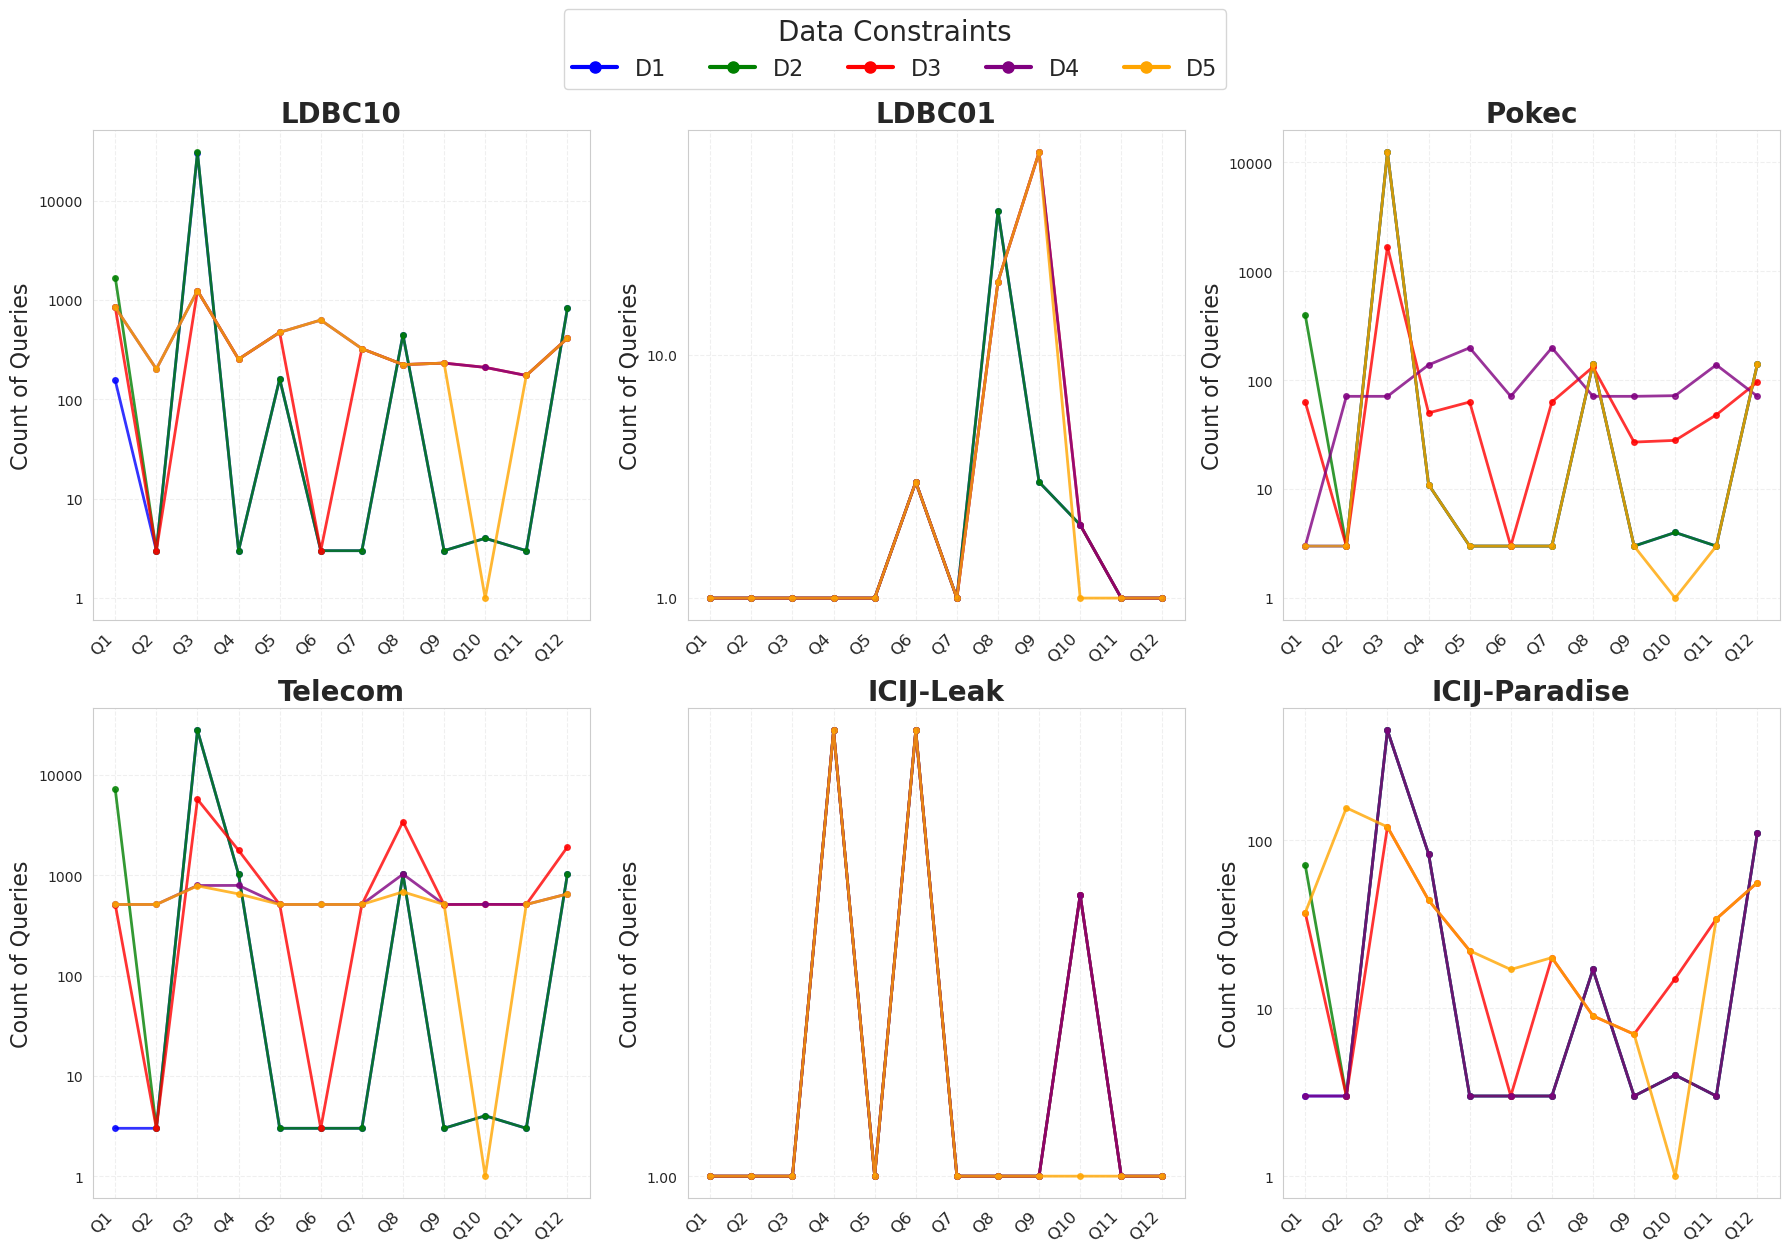

In [96]:
dataset_paths = {
        "LDBC10": "ldbc10/z3_debug.log",
        "LDBC01": "ldbc01/z3_debug.log", 
        "Pokec": "pokec/z3_debug.log",
        "Telecom": "telecom/z3_debug.log",
        "ICIJ-Leak": "icij-leak/z3_debug.log",
        "ICIJ-Paradise": "paradise/z3_debug.log"
    }
    
    # Plot comparison
plot_small_dataset_comparison(dataset_paths, log_scale=True)